# MCA MEMORY PIPELINE FOR FMRI ANALYSIS

## Designing GLM with additional confounds for MCA Subject Level Stat Analysis

### Importing all the necessary OS, shell scripting and imaging operations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
import pandas as pd
import os
from os.path import join, dirname, abspath, isfile, isdir, split, splitext, exists, basename
import sys
import subprocess
import re
import glob
import argparse
import shutil
import json
import nibabel as nib
from nilearn import plotting
from nilearn.image import load_img, mean_img, new_img_like, resample_to_img, threshold_img, high_variance_confounds
from nilearn import datasets
from nilearn import maskers
from nilearn import signal
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.glm.first_level import FirstLevelModel
from nilearn.interfaces.fsl import get_design_from_fslmat
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_epi, plot_contrast_matrix
from nilearn.plotting import plot_design_matrix, plot_anat, plot_img, plot_roi, plot_img_on_surf


In [2]:
%env

{'ANTSPATH': '/Users/vogtlab/ants/bin',
 'COMMAND_MODE': 'unix2003',
 'DISPLAY': '/private/tmp/com.apple.launchd.yMFDVx09Gh/org.xquartz:0',
 'FSLDIR': '/Users/vogtlab/fsl',
 'FSLGECUDAQ': 'cuda.q',
 'FSLMULTIFILEQUIT': 'TRUE',
 'FSLOUTPUTTYPE': 'NIFTI_GZ',
 'FSLTCLSH': '/Users/vogtlab/fsl/bin/fsltclsh',
 'FSLWISH': '/Users/vogtlab/fsl/bin/fslwish',
 'FSL_LOAD_NIFTI_EXTENSIONS': '0',
 'FSL_SKIP_GLOBAL': '0',
 'HDF5PATH': '/Users/vogtlab/hdf5/Contents/bin',
 'HOME': '/Users/vogtlab',
 'LOGNAME': 'vogtlab',
 'MATLABPATH': '/Applications/MATLAB_R2021b.app/bin',
 'MallocNanoZone': '0',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/usr/local/bin:/Users/vogtlab/Library/Python/3.11/bin:/Applications/MATLAB/spm12/bin:/Applications/MATLAB_R2021b.app/bin::/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/python3.11/site-packages:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/fsl/share/fsl/bin:/Users/vogtlab/c3d/Contents/bin:/Users/vogtlab/ants/bin:/usr/local/lib/p

### Path and Folders

For preparing the WM, CSF CompCor Eigenseries from FSL FEAT results for a consolidated GLM matrix with new confounds, the following paths are set and the necessary files are globbed from the initial feat_folders run before incorporating the CompCor components.

In [2]:
MNIpath = os.environ['FSLDIR']
MNI_file = MNIpath + '/data/standard/MNI152_T1_2mm_brain.nii.gz'
MCA_path = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/'
MCA_datapath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA*/Mem*_func/MCA*_corrected.nii.gz'
MCA_featpath = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat'

In [3]:
MNI_file

'/Users/vogtlab/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [4]:
# list all the newest feat folders created in this month in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/

feat_folders = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat')
feat_folders.sort()


In [49]:
feat_folders 

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m2_Pre_04022024_142854.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_

In [25]:
feat_folders_trial = feat_folders[46:50]
feat_folders_trial


['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat']

### In case of subject-specific anatomical masks- needs edits/ done for trials

In [8]:
# copy all the files called highres.nii.gz in the feat folders to the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ into corresponding filenames
for feat_folder in feat_folders:
    # find the MNI registered T1 file called highres.nii.gz in the feat folder
    reg_title = glob.glob(feat_folder + reg_standard/reg/highres.nii.gz')
    # copy the file highres.nii.gz to the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ into corresponding filenames
    shutil.copy(reg_title[0], Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/' + os.path.basename(feat_folder) + '.nii.gz')

# list all the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/   
anat_files = glob.glob(Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA*_Pre_010*.nii.gz')
anat_files.sort()
anat_files

['/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain1_Pre_01082024_192248.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain2_Pre_01082024_192248.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain2_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain1_Pre_01082024_232205.feat.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain2_Pre_01082024_2

In [12]:
# replace the extension of the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/ with .nii.gz
for anat_file in anat_files:
    os.rename(anat_file, anat_file.replace('.feat.nii.gz', '_highres_reg.nii.gz'))

# list all the files called highres.nii.gz in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat
anat_files = glob.glob(Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA*_Pre_010*.nii.gz')
anat_files.sort()
anat_files


['/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain1_Pre_01082024_192248_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA02_Pain2_Pre_01082024_192248_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA03_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA04_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA05_Pain2_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/anat/NLA07_Pain1_Pre_01082024_232205_highres_reg.nii.gz',
 '/Volumes/cerebro/

In [ ]:
# copy all the files called examplefunc2standard.mat transformation matrices in the feat folders
for feat_folder in feat_folders:
    # find the .mat file in the feat folder
    reg_mat = glob.glob(feat_folder + 'reg/example_func2standard.mat')
    # copy the file into corresponding filenames by removing the extension .feat
    shutil.copy(reg_mat[0], os.path.abspath(feat_folder) + os.path.basename(feat_folder).replace('.feat', '.mat'))
    

## Registration for Filtered Functional Data for Stats Runs

### Registration matrices and filtered functional data files from Preprocessed Data

In [5]:
# list all the .mat files 
mat_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/reg/example_func2standard.mat')
mat_files.sort()
mat_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/reg/exam

In [4]:
# list all func files
func_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data.nii.gz')
func_files.sort()
func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered_func_data.nii.gz',
 '/V

In [5]:
# list all func files
func_files_reg = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg.nii.gz')
func_files_reg.sort()
func_files_reg

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered

### Trial Dataset

In [5]:
feat_folders_trial = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*_v3.feat')
feat_folders_trial.sort()
feat_folders_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831_v3.feat']

In [6]:
mat_files_trial = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*_v3.feat/reg/example_func2standard.mat')
mat_files_trial.sort()
mat_files_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat']

In [7]:
func_files_trial = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*_v3.feat/filtered_func_data.nii.gz')
func_files_trial.sort()
func_files_trial


['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz']

In [19]:
MNI_file

'/Users/vogtlab/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [8]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
for i in range(len(mat_files_trial)):
    # register the functional images in func_file_trial to the MNI space using the .mat transformation matrices in mat_files_trial
    # print statemennt saying which file is being registered
    print('Registering ' + func_files_trial[i] + ' to MNI space using ' + mat_files_trial[i])
    subprocess.run(['flirt', '-in', func_files_trial[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files_trial[i], '-out', func_files_trial[i].replace('.nii.gz', '_reg.nii.gz')])

Registering /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz to MNI space using /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat
Registering /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz to MNI space using /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat
Registering /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/filtered_func_data.nii.gz to MNI space using /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/reg/example_func2standard.mat
Registering /Volumes/cerebro/Studies/

### Applying Registration to the filtered func data in each of the feat folders from previously computed transformation matrices

LINEAR REGISTRATION: FLIRT

In [ ]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
# for i in range(len(feat_folders)):
for i in range(0, 1): # loop through 292 MEM feat_folders
    # print the file being processed
    print(os.path.basename(feat_folders[i]))

    if exists(func_files[i].replace('.nii.gz', '_reg.nii.gz')):
        print(os.path.basename(feat_folders[i])+ ' registered.')
        continue
    else:
        # register the functional images  to the MNI space using the .mat transformation matrices in reg_mat_files   
        subprocess.run(['flirt', '-in', func_files[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files[i], '-out', func_files[i].replace('.nii.gz', '_reg.nii.gz')])
        # print statemennt saying which file is being registered
        print('Registered ' + func_files[i] + ' to MNI space using ' + mat_files[i])

NON_LINEAR REGISTRATION: FNIRT AND APPLYWARP - not applied for 3rd Level Runs after inspecting trial runs from MCA 10,11,115,and 116

FSL wrapper for FNIRT not working in subprocess as in the cell below. Pls run /MCA_FMRI/Public/Data/MCA_MEM_firstlevel_FNIRT.sh for the non-linear registrations.

In [ ]:
# use FSL registration tool for warping (NON_LINEAR REG using FNIRT and applywarp) the functional images to the MNI space using the .mat transformation matrices
# for i in range(len(feat_folders)):
for i in range(46, 47): # loop through 292 MEM feat_folders
    # print the file being processed
    print(os.path.basename(feat_folders[i]))

    if exists(func_files_reg[i].replace('.nii.gz', '_wpd.nii.gz')):
        print(os.path.basename(feat_folders[i])+ ' registered with FNIRT.')
        continue
    else:
        in_file=feat_folders[i]+'/reg/highres2standard.nii.gz'
        print(in_file)
        cout_file=feat_folders[i]+'/reg/non_lin_anat.mat'
        print(cout_file)
        iout_file=feat_folders[i]+'/reg/non_lin_anat.nii.gz'
        print(iout_file)
        # register the functional images  to the MNI space using the .mat transformation matrices in reg_mat_files   
        subprocess.run(['fnirt', '--in=', in_file, '--ref=', MNI_file, '--cout=', cout_file, '--iout=', iout_file, '--warpres=10,10,10', '--splineorder=2'])

        # apply the warps to the functional images
        warp_file=feat_folders[i]+'reg/non_lin_anat.mat'
        print(warp_file)
        premat_file=feat_folders[i]+'/reg/example_func2highres.mat'
        print(premat_file)
        subprocess.run(['applywarp', '--ref=', MNI_file, '--in=', func_files_reg[i], '--warp=', warp_file, '--premat=', premat_file, '--out=', func_files_reg[i].replace('.nii.gz', '_wpd.nii.gz')])
        # print statemennt saying which file is being registered
        print('Registered ' + func_files_reg[i] + ' to MNI space. Warps applied for non-linear distortions.')

In [9]:
# call the bash script for Non-Linear Registration
!bash /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_MEM_firstlevel_FNIRT.sh

Memory Data MCA116_Ses1_Mem1 FNIRT done already. Skipping to next FEAT...
Memory Data MCA116_Ses1_Mem2 FNIRT done already. Skipping to next FEAT...
Memory Data MCA116_Ses2_Mem1 FNIRT done already. Skipping to next FEAT...
Memory Data MCA116_Ses2_Mem2 NOT warped...
Registered Functional Data Input: /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat/filtered_func_data_reg.nii.gz
Registered MCA116_Ses2_Mem2 to MNI space. Warps applied for non-linear distortions.


In [ ]:
# rename First_Level_Subj_Analyses folders 
for i in range(len(feat_folders)):
    # rename the folder with copy suffix to trial
    os.rename(feat_folders[i], feat_folders[i].replace('.feat copy', '_trial.feat'))

In [10]:
# list all the registered functional images in the feat folders
reg_func_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg.nii.gz')
reg_func_files.sort()
reg_func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered

In [10]:
# list all the non-linear registered functional images in the feat folders
reg_wpd_func_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*_v3.feat/filtered_func_data_reg.nii.gz')
reg_wpd_func_files.sort()
reg_wpd_func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz']

In [11]:
len(reg_func_files) 
len(reg_wpd_func_files)

294

In [15]:
# check if the legth of the files in reg_mat_files and func_files are the same as the length of the feat_folders
len(mat_files) == len(func_files) == len(feat_folders) == len(reg_func_files) == len(reg_wpd_func_files)

True

Compute the mean of the registered functional files for underlay

In [13]:
# compute the mean of all the files in reg_func_files
mean_reg_func = mean_img(reg_func_files)
mean_reg_func

In [12]:
# compute the mean of all the files in reg_func_files
mean_reg_wpd_func = mean_img(reg_wpd_func_files) # 116 trial subj
mean_reg_wpd_func

In [16]:
# save the mean image as mean_reg_func.nii.gz 
mean_reg_func_file = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/mean_reg_func_mem.nii.gz'
# mean_reg_func.to_filename(mean_reg_func_file)



In [15]:
# save the mean image as mean_reg_wpd_func.nii.gz
mean_reg_wpd_func_file = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/mean_reg_wpd_func_mem_116.nii.gz'
# mean_reg_wpd_func.to_filename(mean_reg_wpd_func_file)

## CompCor Computation

Resampling of the masks are done below. The WM and CSF masks are accessed from the ICBM MNI WM and CSF templates from nilearn repository and resampled to the mean reg functional file from MCA dataset to apply them for 5 CompCor components

In [11]:
# Define the filenames for original and resampled mask file paths for WM and CSF
mask_file_WM = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_WM = mask_file_WM.replace('.nii.gz', '_mem_resampled_to_meanfunc_75.nii.gz') # 0.5 thresholding vs 0.99 thresholding vs 0.75 thresholding

mask_file_CSF = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_CSF = mask_file_CSF.replace('.nii.gz', '_mem_resampled_to_meanfunc_75.nii.gz')

In [16]:
# Define the filenames for original and resampled mask file paths for WM and CSF
resampled_mask_file_wpd_WM = mask_file_WM.replace('.nii.gz', '_mem_wpd_resampled_to_meanfunc_75.nii.gz') # 0.5 thresholding vs 0.99 thresholding vs 0.75 thresholding

resampled_mask_file_wpd_CSF = mask_file_CSF.replace('.nii.gz', '_mem_wpd_resampled_to_meanfunc_75.nii.gz')

In [18]:
print(resampled_mask_file_CSF)
print(resampled_mask_file_WM)
print(mean_reg_wpd_func_file)

/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a_mem_resampled_to_meanfunc_75.nii.gz
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a_mem_resampled_to_meanfunc_75.nii.gz
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/mean_reg_wpd_func_mem_116.nii.gz


In [19]:
# defining the filename combine the resampled mask images for WM and CSF
combined_mask_file = resampled_mask_file_WM.replace('wm', 'WM+CSF')  
combined_mask_file

'/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_mem_resampled_to_meanfunc_75.nii.gz'

In [17]:
# load data
img_wm_mask = load_img(mask_file_WM) 
img_csf_mask = load_img(mask_file_CSF)

# image operation to combine the resampled mask images for WM and CSF
img_combined_mask = new_img_like(img_wm_mask, img_wm_mask.get_fdata() + img_csf_mask.get_fdata())

# resample the mask to match mean file's resolution/dimensions
img_combined_mask = resample_to_img(img_combined_mask, mean_reg_wpd_func_file, interpolation = 'nearest')  # mean_reg_func_file for linear reg

# binarise the combined mask image
img_combined_mask = threshold_img(img_combined_mask, threshold=0.75)
img_combined_mask.to_filename(combined_mask_file)


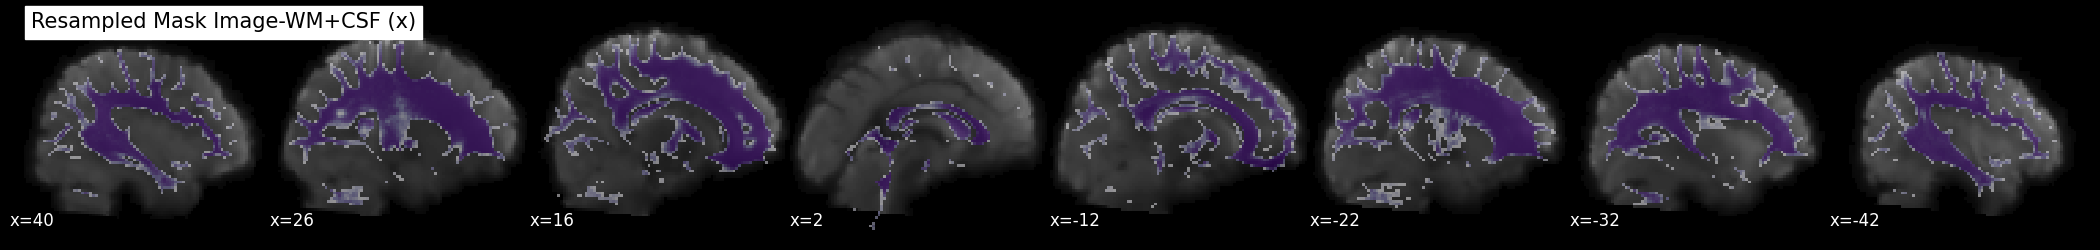

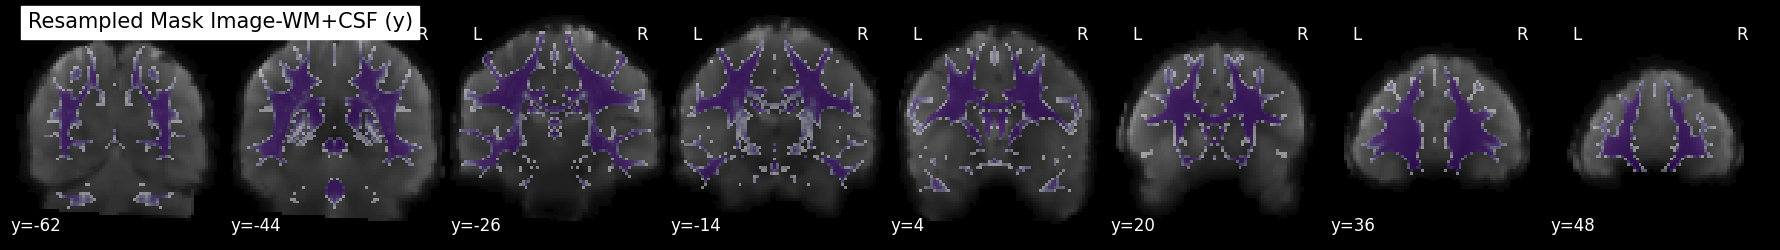

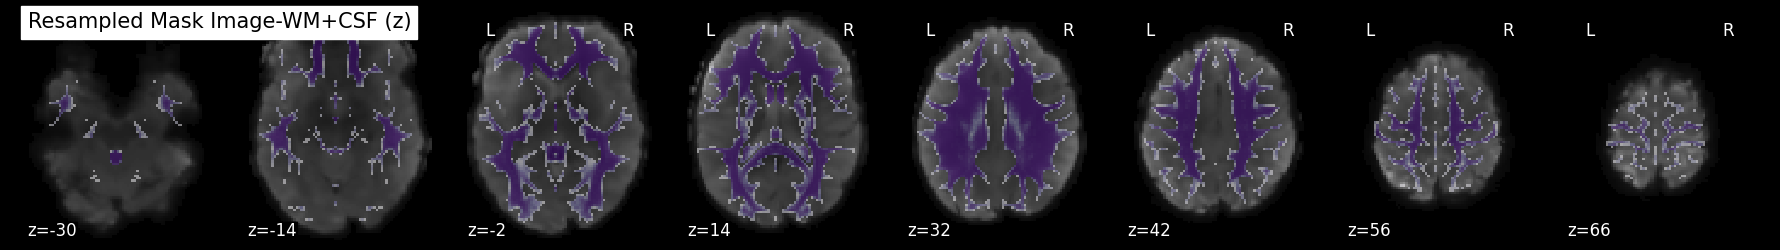

In [43]:
# Computing the WM and CSF masks for trial data from MCA dataset

# Load the example func .nii.gz file for resampling the mask image
in_file =  reg_func_files[1]
img = load_img(in_file)


# plot the resampled mask image on the in_file mean image using nilearn plotting
mean_reg_sub_file = mean_img(in_file)

# Create a montage of slices in x, y and z directions
for display_mode in ['x', 'y', 'z']:
    # plotting.plot_roi(resampled_mask_file_WM, mean_reg_sub_file, title=f"Resampled Mask Image-WM ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Reds', linewidths=5, alpha=0.5)
    # #savefig(f"Resampled Mask Image-WM ({display_mode}).png")
    # plotting.plot_roi(resampled_mask_file_CSF, mean_reg_sub_file, title=f"Resampled Mask Image-CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Blues', linewidths=5, alpha=0.5)
    #savefig(f"Resampled Mask Image-CSF ({display_mode}).png")
    plotting.plot_roi(combined_mask_file, mean_reg_sub_file, title=f"Resampled Mask Image-WM+CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Purples', linewidths=5, alpha=0.5)

plotting.show()


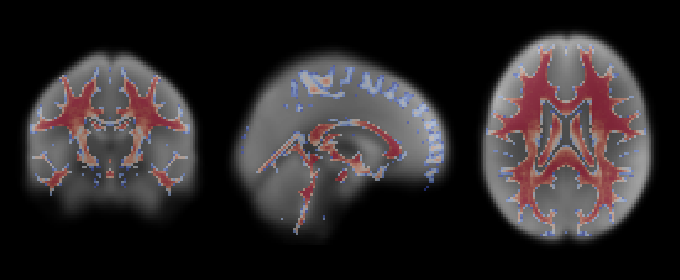

In [42]:
func_underlay = mean_reg_func_file
# plotting "Resampled Mask Image-WM+CSF" on the mean_reg_func image
plotting.plot_roi(combined_mask_file, func_underlay, title=None, display_mode='ortho', colorbar=False, cmap='coolwarm', linewidths=5, alpha=0.5, draw_cross=False, annotate=False, black_bg=True, axes=None)

Function Defined for the CompCor Using FSL ImageMeanTS

In [44]:
reg_func_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/filtered

In [35]:
combined_mask_file

'/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/templates/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_resampled_to_meanfunc_75.nii.gz'

In [20]:
# Eigen series for all the registered functional images in the feat folders
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.image import load_img, new_img_like, math_img
n_compcor_components=5

# for i in range(len(reg_func_files)):
for i in range(0, 4):
    ifile = reg_wpd_func_files[i]
    out_file = os.path.join(dirname(ifile), basename(ifile).replace('.nii.gz', '_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv')) # combined mask from WM and CSF

    if exists (out_file):
        print(f'{out_file} already created. Skipping process..')
        continue
    else:
        print(f'Processing {ifile}')
        
        # print number of volumes in the file
        img = load_img(ifile)
        print(f'Number of volumes: {img.shape[-1]}')
        
        

        # Compute eigen series
        res = ImageMeants(in_file=ifile,
                        mask=combined_mask_file, # can be changed to 0.5 or 0.75 thresholded mask instead of the 0.99 mask
                        out_file=out_file,
                        order=n_compcor_components,
                        eig=True,
                        show_all=True,
                        terminal_output='stream').run()
        
        # show command line in output
        print('ImageMeants OUTPUTS:')
        print(out_file)


Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz
Number of volumes: 491
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv
Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz
Number of volumes: 487
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv
Processing /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg.nii.gz
Number of volumes: 494
ImageMeants OUTPUTS:
/Volumes/cerebro/Studies/MCA_FMRI/Publ

The CompCor data are stored as FSL compatible .txt format to provide in the GUI for appending to the previously designed GLM matrix for their corresponding functional data.

### Display/ View CompCor Components as Time Series

In [22]:
eigen_series = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv')    
eigen_series.sort()
eigen_series

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv']

In [ ]:
# plot the combined components of WM and CSF with the corresponding title
for i in range(len(eigen_series)):
    # plot the eigen_series_CSF.tsv files
    plt.figure(figsize=(20, 5))
    plt.plot(np.loadtxt(eigen_series[i]))
    plt.title(os.path.basename(feat_folders[i]) + '---' + os.path.basename(eigen_series[i]))
    plt.xlabel('Volumes')
    plt.ylabel('Component Values')
    # plt.legend()
   
    plt.show()
    # save the plot as a png file in the path NLAcerebropath
    plt.savefig(eigen_series[i].replace('.tsv', '.png'))

## Combine All Values for Extended GLM

### Concatenate Previous Design (3 Timing Files and derivatives, 6 Motion Parameters) TSVs,  eigen_series_n*_WMCSF_ICBM_MNI.tsv and motion outlier files

In [47]:
len(eigen_series)

294

In [23]:
# get all design.mat files as dataframes and concatenate the eigen_series.tsv files as new columns
# for i in range(len(feat_folders)):
for i in range(0, 4): # trial loop (MCA12 Ses 1 and Ses2 have dimensionality error- no original data for fixing error
    
    matrix_path = feat_folders_trial[i] + '/design.mat'
    df_init = get_design_from_fslmat(matrix_path, column_names=None)   # gets the design matrix from the .mat file as a dataframe
    #print number of columns in the initial design matrix
    print('Number of columns in the initial design matrix: ' + str(df_init.shape[1]) + ' for ' + matrix_path)
    # drop first six columns of the design matrix which are the task timing and derivative for RorK, FGT and SHK; rerunning FEAT sh script will regenerate these columns
    df_init = df_init.drop(df_init.columns[[0, 1, 2, 3, 4, 5]], axis=1) 

    # the new dataframe has only 6 columns:6 Motion Parameters; avoiding a reconcatenation of the motion.par files for the design matrix
    if df_init.shape[1] < 6:
        print('ERROR: Number of columns in the initial Motion Parameter design is not correct for ' + 'matrix_path') 

    # read the combined eigen_series.tsv file
    df_CmCr_n5 = pd.read_csv(eigen_series[i], header=None, sep='  ', engine='python')

    if df_CmCr_n5.shape[1] != 5:
        print('ERROR: Number of columns in the eigen series is not 5 for ' + eigen_series[i])

    #concate the motion parameters and eigen_series_n5 files as columns in a new dataframe
    df_combined_design = pd.concat([df_init, df_CmCr_n5], axis=1)

    # drop any NaN columns in the dataframe
    # df_design_n5 = df_design_n5.dropna(axis=1)
  
        
    # save the concatenated files as a txt file for EVs to FSL FEAT
    combined_design = eigen_series[i].replace('_eigen_series_n5_WMCSF_ICBM_MNI_v3.tsv', '_mp6_fdrms1pt5_CmCrn5_trial_v3.txt') # a new filename for n5
    df_combined_design.to_csv(combined_design, index=False, header=False, sep='\t') # save the file as a tab separated txt file
    # print the number of columns in the new design matrix
    print('Number of columns in the combined design matrix: ' + str(df_combined_design.shape[1]) + ' for ' + combined_design)
    print('Saved ' + combined_design)


Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5_trial_v3.txt
Saved /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831_v3.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5_trial_v3.txt
Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831_v3.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5_trial_v

Now the TSVs files are consolidated into a single dataframe for each subject which can be fed as a .txt file as for subject level stats with the modified GLM.

In [ ]:
# check variance inflation factor for multicollinearity in the design matrix
for i in range(len(feat_folders)):
    # read the combined eigen_series.tsv file
    df_combined_design = pd.read_csv(feat_folders[i] + '/filtered_func_data_reg_wpd_eigen_series_n5_WMCSF_ICBM_MNI.tsv', header=None, sep='  ', engine='python')
    # compute the variance inflation factor for the design matrix
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df_combined_design.values, i) for i in range(df_combined_design.shape[1])]
    vif["features"] = df_combined_design.columns
    print(vif)

In [57]:
MCA_featpath

'/Volumes/cerebro/Studies/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat'

In [59]:
# list all the combined_design files in the NLAcerebropath in ascending order
combined_design_files = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt') 
combined_design_files.sort()
combined_design_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/filtered_func_data_reg_mp6_fdrms1pt5_CmCrn5.txt',
 '/Volumes/cereb

MCA MEM Second time runs for subject-level analyses with new combined GLM design are done using **MCA_MEM_firstlevelSTATSONLY_FEAT_checks.sh**

### GLM Schematic Representation - template

In [ ]:
design_matrix = pd.read_csv('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', delimiter='\t', engine='python')
design_matrix

In [ ]:
glm_header = ['PainStim', 'PainStim_der', 'Motion1', 'Motion2', 'Motion3', 'Motion4', 'Motion5', 'Motion6', 'MotionOutlier', 'WM-CSF1', 'WM-CSF2', 'WM-CSF3', 'WM-CSF4', 'WM-CSF5']

In [ ]:
# glm = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA02/Pain_func1/NLA02_Pain1_Pre_01082024_192248.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=None)
glm_24_2 = get_design_from_fslmat('/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/NLA24/Pain_func2/NLA24_Pain2_Pre_01082024_105037.feat/filtered_func_data_reg_Stats_CmCr-n5_01192024_114200.feat/design.mat', column_names=glm_header)
glm_24_2

PainStim  PainStim_der   Motion1   Motion2   Motion3   Motion4   Motion5  \
0    0.000432      0.001321 -0.006232  0.000286  0.002246 -0.158097 -0.262990   
1    0.001945      0.001217 -0.005267  0.000656  0.001351 -0.100805 -0.129577   
2    0.003251      0.000965 -0.002222 -0.000165  0.000164 -0.017164  0.157188   
3    0.004261      0.000634 -0.001348  0.000639 -0.000215 -0.033146 -0.005240   
4    0.004904      0.000235 -0.001072  0.000556 -0.000247 -0.032209 -0.026327   
..        ...           ...       ...       ...       ...       ...       ...   
220  0.031672      0.004728 -0.001780  0.000071 -0.000065 -0.075909 -0.160180   
221  0.036030      0.003605  0.000399  0.000429 -0.000639 -0.042378 -0.137904   
222  0.039272      0.002497  0.001732  0.000517 -0.001101  0.011181  0.060865   
223  0.041413      0.001403  0.001671  0.000998 -0.001239  0.016913  0.075061   
224  0.042468      0.000860  0.000693  0.000549 -0.000008  0.064331  0.167628   

      Motion6  MotionOutlier   WM-CSF1   WM-CSF2   WM-CSF3   WM-CSF4   WM-CSF5  
0   -0.571085       2.434295 -0.370568 -2.999925  0.922435 -2.482751 -0.000034  
1   -0.263743       1.117013  0.148882 -1.224075  0.382823 -0.568414 -0.000034  
2    0.117047      -0.507475  0.722705  0.470433 -0.150818 -0.176656 -0.000034  
3    0.024543      -0.390560  0.351657  0.515529 -0.319497  0.984169 -0.000034  
4    0.077040      -0.120443  0.339184  0.372240 -0.307136  0.749627 -0.000034  
..        ...            ...       ...       ...       ...       ...       ...  
220  0.035263      -0.107091  0.358248 -0.122663  0.028355  0.708232 -0.000034  
221  0.038824       0.299066  0.078920 -0.047810 -0.098664  0.474307 -0.000034  
222  0.145779      -0.156844  0.017973  0.136252 -0.177790 -0.149912 -0.000034  
223  0.144708      -0.331277  0.084387  0.497855 -0.215088  0.208701 -0.000034  
224  0.162361      -0.588979  0.281282  1.015855 -0.238455 -0.191681 -0.000034  

[225 rows x 14 columns]

<Axes: label='conditions', ylabel='scan number'>

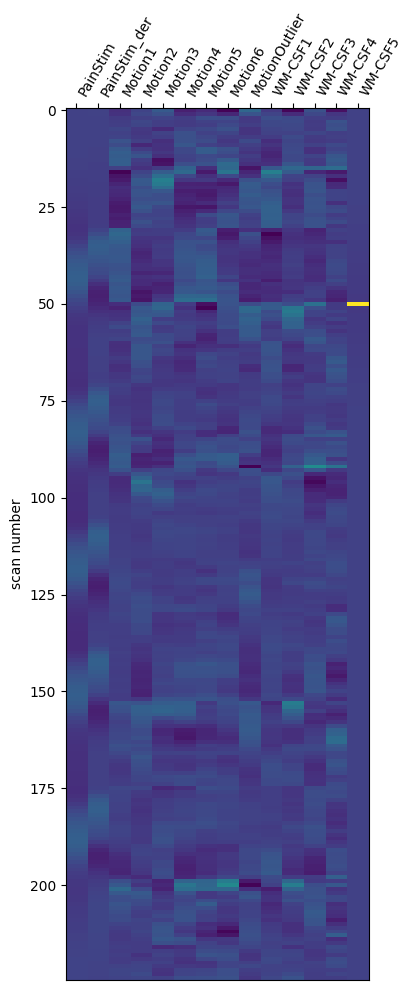

In [ ]:
plot_design_matrix(glm_24_2)

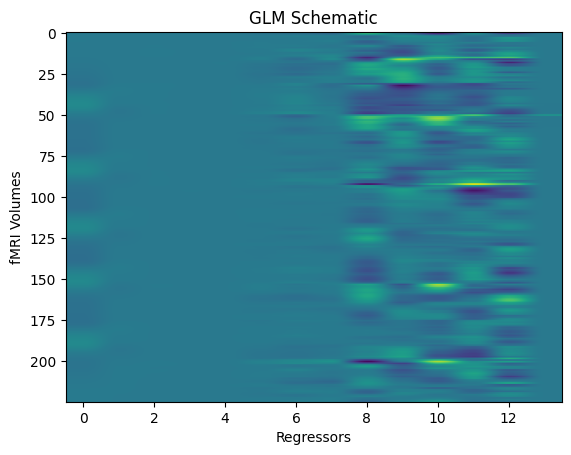

In [ ]:
plot_design_matrix(glm_24_2)

<Axes: label='conditions', ylabel='scan number'>

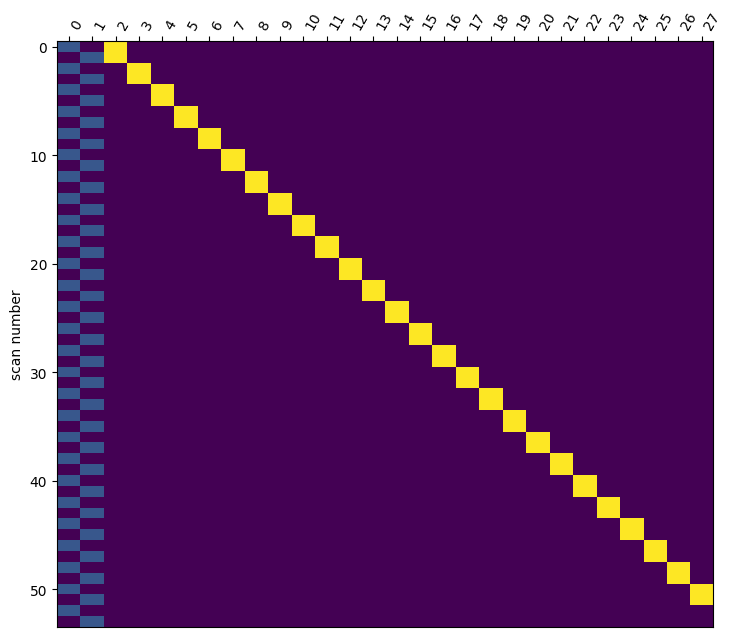

In [ ]:
#plot gp_stats model
gp_stats = '/Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/Group_Analysis/Gp_Ana_n27_z2-p05_ME12_fdrms1pt5_CmCr-n5_02072024_112000.gfeat/cope1.feat/design.mat'
gp_stats = get_design_from_fslmat(gp_stats, column_names=None)
plot_design_matrix(gp_stats)


In [ ]:
for i in range(len(combined_design_files)):
    mp_cmcr_n5 = pd.read_csv(combined_design_files[i], header=None, delimiter='\t', engine='python')
    plot_design_matrix(mp_cmcr_n5)

## First Level Stats Run with Extended GLM 

Stats runs are done again for the feat_folders processed in the above steps with the new consolidated confounds for the GLM design using **MCA_MEM_firstlevelSTATSONLY_FEAT_checks.sh** as below:

In [30]:
!bash /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_MEM_firstlevelSTATSONLY_FEAT_checks.sh

Memory Data MCA116_Ses1_Mem1 NOT processed with full confounds...
Functional Data Input: /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/filtered_func_data_reg_wpd.nii.gz
Memory Data MCA116_Ses1_Mem1 being processed...
Found Confounds Matrix : MCA116_Ses1_Mem1
Running First Level Stats for MCA116_Ses1_Mem1 with full confound set...
Memory Data MCA116_Ses1_Mem1 processed with full confound set.
Memory Data MCA116_Ses1_Mem2 NOT processed with full confounds...
Functional Data Input: /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat/filtered_func_data_reg_wpd.nii.gz
Memory Data MCA116_Ses1_Mem2 being processed...
Found Confounds Matrix : MCA116_Ses1_Mem2
Running First Level Stats for MCA116_Ses1_Mem2 with full confound set...
Memory Data MCA116_Ses1_Mem2 processed with full confound set.
Memory Data MCA116_Ses2_Mem1 NOT processed with full confounds...
Function

## MCA Group Analysis

### STATS ONLY ORIGINAL REGISTRATION

### MEM reg and reg_standard folders - Creating reg and reg_standard for StatsOnly feat directories # FSL workaround for reducing time apparently

New copies of reg_standard folders from prior FEAT runs are saved in Stats.feat folders to avoid 'missing reg setup' error in higher level stats run. See Mac notes on Jan 24, 2024 for all the points and workaround options

In [47]:
feat_folders

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m2_Pre_04022024_142854.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_

In [43]:
statsonly_folders = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-*-m*_Pre_*_*.feat/116-*-m*_Stats_trial_wpd.feat')    
statsonly_folders.sort()
statsonly_folders

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat/116-1-m2_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat/116-2-m1_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat/116-2-m2_Stats_trial_wpd.feat']

In [7]:
# for i in range(len(feat_folders)):
for i in range(0, 292): # trial loop 
    
    if exists(statsonly_folders[i] + '/reg/') and exists(statsonly_folders[i] + '/reg_standard/'):
        print(f'Reg folders exists for {os.path.basename(statsonly_folders[i])}. Skipping...')
        continue

    else:
        # copy the reg folder from the feat folder to the StatsOnly.feat
        print(f'Copying reg for {os.path.basename(feat_folders[i])}')    
        shutil.copytree(feat_folders[i] + '/reg/', statsonly_folders[i] + '/reg/')
        # call a subprocess using featregapply
        print('Creating reg_standard for ' + statsonly_folders[i])
        # call the featregapply function
        subprocess.run(['featregapply', statsonly_folders[i]])
        print('Done for:', os.path.basename(feat_folders[i]))



Reg folders exists for 10-1-m1_Stats.feat. Skipping...
Reg folders exists for 10-1-m2_Stats.feat. Skipping...
Reg folders exists for 10-2-m1_Stats.feat. Skipping...
Reg folders exists for 10-2-m2_Stats.feat. Skipping...
Reg folders exists for 100-1-m1_Stats.feat. Skipping...
Reg folders exists for 100-1-m2_Stats.feat. Skipping...
Reg folders exists for 100-2-m1_Stats.feat. Skipping...
Reg folders exists for 100-2-m2_Stats.feat. Skipping...
Reg folders exists for 103-1-m1_Stats.feat. Skipping...
Reg folders exists for 103-1-m2_Stats.feat. Skipping...
Reg folders exists for 103-2-m1_Stats.feat. Skipping...
Reg folders exists for 103-2-m2_Stats.feat. Skipping...
Reg folders exists for 104-1-m1_Stats.feat. Skipping...
Reg folders exists for 104-1-m2_Stats.feat. Skipping...
Reg folders exists for 104-2-m1_Stats.feat. Skipping...
Reg folders exists for 104-2-m2_Stats.feat. Skipping...
Reg folders exists for 105-1-m1_Stats.feat. Skipping...
Reg folders exists for 105-1-m2_Stats.feat. Skipping

### TRIALS TO FIX REG ERROR -- June 26, 2024

In [44]:
# list all the newest feat folders created in this month in the path /Volumes/cerebro/Studies/VOGT/NeuCLA/Public/Data/

feat_folders_trial = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-*_Pre*143831.feat')
feat_folders_trial.sort()
feat_folders_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat']

In [45]:
feat_folders_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat']

In [38]:
# rename First_Level_Subj_Analyses folders for trial set
for i in range(len(feat_folders_trial)):
    # rename the folder with copy suffix to trial
    os.rename(feat_folders_trial[i], feat_folders_trial[i].replace('.feat copy', '_trial.feat'))

In [42]:

#glob all folders of form 116-1-m1_Pre_06262024_trial.feat
statsonly_folders_trial = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-*-m*_Pre_*_*.feat/116-*-m*_Stats_trial_wpd.feat')
statsonly_folders_trial.sort()
statsonly_folders_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat/116-1-m2_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat/116-2-m1_Stats_trial_wpd.feat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m2_Pre_03112024_143831.feat/116-2-m2_Stats_trial_wpd.feat']

In [22]:
range(len(statsonly_folders_trial))

range(0, 10)

FSL featregapply workaround instrustions from : https://mumfordbrainstats.tumblr.com/post/166054797696/feat-registration-workaround


In [46]:
##trial : second reg to reg_std for 116*Pre_06262024_trial.feat/*Stats.feat
# loop for 4 iterations
for i in range(len(statsonly_folders)):
        print('Creating mat files for ' + statsonly_folders[i])
        #delete reg_standard folder if it exists in the feat_folders_trial
        if exists(feat_folders_trial[i] + '/reg_standard/'):
                shutil.rmtree(feat_folders_trial[i] + '/reg_standard/')
                print('Deleted reg_standard for ' + feat_folders_trial[i])

        # delete reg_standard folder if it exists in the StatsOnly.feat folder
        if exists(statsonly_folders[i] + '/reg_standard/'):
            shutil.rmtree(statsonly_folders[i] + '/reg_standard/')
            print('Deleted reg_standard for ' + statsonly_folders[i])

        # if reg folder does not exist in statsonly_folders_trial[i], copy the reg folder from feat_folders_trial[i] to statsonly_folders_trial[i]
        if not exists(statsonly_folders[i] + '/reg/'):
                shutil.copytree(feat_folders_trial[i] + '/reg/', statsonly_folders[i] + '/reg/')
                print('Copied reg for ' + os.path.basename(feat_folders_trial[i]) + ' to ' + os.path.basename(statsonly_folders[i]))

        # copy identity matrix to the reg folder from FSLDIR
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/example_func2standard.mat') # workaround from forum
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/standard2example_func.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/standard2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/highres2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/example_func2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/highres2example_func.mat')

        #copy mean_func to the reg folder as standard.nii.gz
        shutil.copy(statsonly_folders[i] + '/mean_func.nii.gz', statsonly_folders[i] + '/reg/standard.nii.gz')

        # copy identity matrix to the reg folder to feat folders trial
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/example_func2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/standard2example_func.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/standard2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/highres2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/example_func2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders_trial[i] + '/reg/highres2example_func.mat')

        #copy mean_func to the reg folder as standard.nii.gz
        # shutil.copy(feat_folders_trial[i] + '/mean_func.nii.gz', feat_folders_trial[i] + '/reg/standard.nii.gz') # workaround from forum
        shutil.copy(MNI_file, feat_folders_trial[i] + '/reg/standard.nii.gz')
        
        print('All .mat files replaced by Identity matrix for:', os.path.basename(feat_folders_trial[i]))

Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats_trial_wpd.feat
Deleted reg_standard for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats_trial_wpd.feat
All .mat files replaced by Identity matrix for: 116-1-m1_Pre_03112024_143831.feat
Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat/116-1-m2_Stats_trial_wpd.feat
Deleted reg_standard for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m2_Pre_03112024_143831.feat/116-1-m2_Stats_trial_wpd.feat
All .mat files replaced by Identity matrix for: 116-1-m2_Pre_03112024_143831.feat
Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-2-m1_Pre_03112024_143831.feat/116-2-m1_Stats_trial_wpd.fe

In [ ]:
# run fslstats on an example cope file for checking reg_standard vs stat folder cope files in First Level FEAT result folders
# for i in range(len(statsonly_folders_trial)): 
# subprocess.run([fslstats /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats.feat/stats/cope1.nii.gz -r -R -x -X])
subprocess.run(['fslstats /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116-1-m1_Pre_03112024_143831.feat/116-1-m1_Stats.feat/reg_standard/stats/cope1.nii.gz -r -R -x -X'])


TRIAL FOR REG ERROR ENDS

### Replicate Identity matrix instead of all .mat files in reg folders

In [50]:
for i in range(len(statsonly_folders)):
        print('Creating mat files for ' + statsonly_folders[i])
        #delete reg_standard folder if it exists in the feat_folders
        if exists(feat_folders[i] + '/reg_standard/'):
                shutil.rmtree(feat_folders[i] + '/reg_standard/')
                print('Deleted reg_standard for ' + feat_folders[i])

        # delete reg_standard folder if it exists in the StatsOnly.feat folder
        if exists(statsonly_folders[i] + '/reg_standard/'):
            shutil.rmtree(statsonly_folders[i] + '/reg_standard/')
            print('Deleted reg_standard for ' + statsonly_folders[i])

        # copy identity matrix to the reg folder
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/example_func2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/standard2example_func.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/standard2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/highres2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/example_func2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', statsonly_folders[i] + '/reg/highres2example_func.mat')

        #copy mean_func to the reg folder as standard.nii.gz
        shutil.copy(statsonly_folders[i] + '/mean_func.nii.gz', statsonly_folders[i] + '/reg/standard.nii.gz')

        # copy identity matrix to the reg folder to feat folders trial
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/example_func2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/standard2example_func.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/standard2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/highres2standard.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/example_func2highres.mat')
        shutil.copy('/usr/local/fsl/etc/flirtsch/ident.mat', feat_folders[i] + '/reg/highres2example_func.mat')

        #copy mean_func to the reg folder as standard.nii.gz
        shutil.copy(feat_folders[i] + '/mean_func.nii.gz', feat_folders[i] + '/reg/standard.nii.gz')
        
        print('All .mat files replaced by Identity matrix for:', os.path.basename(feat_folders[i]))

Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat
Deleted reg_standard for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat
Deleted reg_standard for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat
All .mat files replaced by Identity matrix for: 10-1-m1_Pre_012723_102400.feat
Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat
Deleted reg_standard for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat
All .mat files replaced by Identity matrix for: 10-1-m2_Pre_012823_102400.feat
Creating mat files for /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_S

### STATS ONLY ORIGINAL REGISTRATION - cont'd 

Re-done for deleting reg_standard folders and fixing reg folders w/o featregapply manually :

In [53]:
# list all the reg folders in the StatsOnly.feat folders
reg_folders_new = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/*Stats.feat/reg/')
reg_folders_new.sort()
reg_folders_new

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m1_Pre_012723_102400.feat/10-1-m1_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-1-m2_Pre_012823_102400.feat/10-1-m2_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m1_Pre_032223_102400.feat/10-2-m1_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10-2-m2_Pre_032223_102400.feat/10-2-m2_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m1_Pre_04022024_104429.feat/100-1-m1_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-1-m2_Pre_04022024_104429.feat/100-1-m2_Stats.feat/reg/',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100-2-m1_Pre_04022024_142116.feat/100-2-m1_Stats.feat/reg/',
 '/Volumes/cere

In [51]:
reg_std_folders = glob.glob('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/*_Pre_*.feat/*Stats.feat/reg_standard/')
reg_std_folders.sort()
reg_std_folders

[]

## MEM - Second Level Intermediate Analyses

Make sure the older feat directories that are excluded from the current second level intermediate analysis are moved to /older_first_level/ folder. This will ensure that only the up-to-date edits of the motion outlier thresholds, CompCor computation, combined GLM design are contained in the /First_Level_Subj_Analyses/

In [47]:
First_Level = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/'

In [48]:
# create a dictionary for each subject
# feat_dirs_dict = {}

# get all feat directories from the First_Level directory for a range of subjects from 7 to 116
for sub in range(116, 117):
    feat_dirs = glob.glob(First_Level + '{:d}-*.feat'.format(sub) + '/' + '{:d}-*_Stats_trial_wpd.feat'.format(sub))
    # print the number of feat directories
    # print(len(feat_dirs))

    
    # save the feat directories to a dictionary with the subject number as the key
    # feat_dirs_dict[sub] = feat_dirs

    # print the feat directories as a dictionary
    # print(feat_dirs_dict)

    # save the feat directories to a text file with the subject number if the number of feat directories is equal to 4 for 2 session's Mem1 and Mem2
    if len(feat_dirs) == 4:
        with open(First_Level + '{:d}_feat_dirs_path_wpd_v6.txt'.format(sub), 'w') as f:
            for feat_dir in feat_dirs:
                f.write(feat_dir + '\n')
            print('Created input set for Intermediate level Fixed Effects run:', First_Level + '{:d}_feat_dirs_path_wpd_v6.txt'.format(sub))
        
    # print(feat_dirs)
    


Created input set for Intermediate level Fixed Effects run: /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116_feat_dirs_path_wpd_v6.txt


In [31]:
# get all feat_dirs_path files in the First_Level directory
feat_dirs_path_files = glob.glob(First_Level + '*_feat_dirs_path.txt')
feat_dirs_path_files.sort()
feat_dirs_path_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/100_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/103_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/104_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/105_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/107_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/110_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/111_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/112_feat_dirs_path.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Pu

In [33]:
feat_dirs_path_files_trial = glob.glob(First_Level + '*_feat_dirs_path_trial.txt')
feat_dirs_path_files_trial.sort()
feat_dirs_path_files_trial

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/10_feat_dirs_path_trial.txt',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/116_feat_dirs_path_trial.txt']

RUNNING SECOND LEVEL INTERMEDIATE ANALYSIS BASH SCRIPT:

In [ ]:
!bash /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/MCA_MEM_secondlevel_FEAT_checks.sh # note that the script is replicated with Mac specific suffixes for sub-batch runs within the total 116 subjects

FOR CREATING MATRIX FOR 3RD LEVEL DESIGN:

In [33]:
# get an array of labels from the feat_dirs_path_files
intermed_labels = [os.path.basename(feat_dirs_path_file).replace('_feat_dirs_path.txt', '') for feat_dirs_path_file in feat_dirs_path_files]
intermed_labels

['100',
 '103',
 '104',
 '105',
 '107',
 '10',
 '110',
 '111',
 '112',
 '116',
 '13',
 '18',
 '20',
 '24',
 '25',
 '26',
 '28',
 '29',
 '30',
 '31',
 '33',
 '34',
 '40',
 '41',
 '45',
 '47',
 '49',
 '52',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '65',
 '66',
 '67',
 '68',
 '70',
 '72',
 '73',
 '74',
 '75',
 '76',
 '81',
 '83',
 '86',
 '88',
 '90',
 '92',
 '94',
 '95',
 '98',
 '9']

In [55]:
# get the feat_labels for subjects without feat_dirs_path files i.e unpaired sessions group run inputs
for stat_folder in statsonly_folders:
    if os.path.basename(stat_folder).split('-')[0] not in intermed_labels:
        # print(os.path.basename(stat_folder).split('-')[0], stat_folder + '/stats/cope1.nii.gz' ) # represenstation for the corresponding unpaired sessions cope file inputs
        # print(os.path.basename(feat_folder).split('-')[0]) # labels only
        print(os.path.basename(stat_folder).split('-')[0]+ '-' +os.path.basename(stat_folder).split('-')[1] , stat_folder) # represenstation for the corresponding unpaired sessions stat folders)

106-1 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/106-1-m1_Pre_04292024_122106.feat/106-1-m1_Stats.feat
106-1 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/106-1-m2_Pre_04292024_122106.feat/106-1-m2_Stats.feat
108-2 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/108-2-m1_Pre_03132024_161317.feat/108-2-m1_Stats.feat
108-2 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/108-2-m2_Pre_03132024_161317.feat/108-2-m2_Stats.feat
109-1 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/109-1-m1_Pre_03142024_143424.feat/109-1-m1_Stats.feat
109-1 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/109-1-m2_Pre_03142024_143424.feat/109-1-m2_Stats.feat
11-1 /Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/First_Level_Subj_Analyses/11-1-m1_Pre_012823_102400.feat/11-1-m1_Stats.feat
11-1 /Volumes/cerebro/Stu

In [56]:
# create a eye matrix for the fixed effects analysis of size 37x37
eye_mat = np.eye(37)
eye_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## MEM - Third Level Analyses from 2nd level cope directories

### Paired Sessions

In [22]:
Second_Level = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New'

In [72]:
# get all directories with the feat directories in Second_Level 
feat_2dirs = glob.glob(Second_Level + '/*.gfeat')
feat_2dirs.sort()
feat_2dirs

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA100_FE_05152024_170240.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA103_FE_05172024_125515.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA104_FE_05172024_125515.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA105_FE_05172024_125515.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA107_FE_05172024_125515.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA10_FE_05162024_111811.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA110_FE_05172024_125515.gfeat',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public

In [88]:
# getextract labels from the feat_2dirs
FE_labels_paired = [os.path.basename(feat_2dir).split('_')[2] for feat_2dir in feat_2dirs]
FE_labels_paired


['MCA100',
 'MCA103',
 'MCA104',
 'MCA105',
 'MCA107',
 'MCA10',
 'MCA110',
 'MCA111',
 'MCA112',
 'MCA116',
 'MCA13',
 'MCA18',
 'MCA20',
 'MCA24',
 'MCA25',
 'MCA26',
 'MCA28',
 'MCA29',
 'MCA30',
 'MCA31',
 'MCA33',
 'MCA34',
 'MCA40',
 'MCA41',
 'MCA45',
 'MCA47',
 'MCA49',
 'MCA52',
 'MCA56',
 'MCA57',
 'MCA58',
 'MCA59',
 'MCA60',
 'MCA61',
 'MCA65',
 'MCA66',
 'MCA67',
 'MCA68',
 'MCA70',
 'MCA72',
 'MCA73',
 'MCA74',
 'MCA75',
 'MCA76',
 'MCA81',
 'MCA83',
 'MCA86',
 'MCA88',
 'MCA90',
 'MCA92',
 'MCA94',
 'MCA95',
 'MCA98',
 'MCA9']

In [91]:
# get path for each cope file from the feat_2dirs
for feat_2dir in feat_2dirs:
    # get the cope files from the cope1.nii.gz file in the stats folder
    cope_files = glob.glob(feat_2dir + '/cope1.feat/stats/cope1.nii.gz')
    # print the cope files
    print(cope_files)

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA100_FE_05152024_170240.gfeat/cope1.feat/stats/cope1.nii.gz']
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA103_FE_05172024_125515.gfeat/cope1.feat/stats/cope1.nii.gz']
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA104_FE_05172024_125515.gfeat/cope1.feat/stats/cope1.nii.gz']
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA105_FE_05172024_125515.gfeat/cope1.feat/stats/cope1.nii.gz']
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA107_FE_05172024_125515.gfeat/cope1.feat/stats/cope1.nii.gz']
['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Second_Level_Intermediate_Analyses_New/Gp_2lvl_MCA10_FE_05162024_111811.gfeat/cope1.feat/stats/cope1.nii.gz']

FE_labels_paired are to be sorted for categorizing into saline vs drug groups for third level analysis **(info from MCA - Data Status June 3,2024)**. This will also have info for the unpaired sessions.

### Unpaired Sessions

3rd level Group input paths for unpaired sessions

In [58]:
RorK_path_unpaired = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat'
FGT_path_unpaired = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_FGT_05222024.gfeat'
SHK_path_unpaired = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_SHK_05222024.gfeat'

RorK

In [62]:
RorK_input_unpaired = glob.glob(RorK_path_unpaired + '/cope1.feat/stats/cope*.nii.gz')
# RorK_path_unpaired.sort()
RorK_input_unpaired

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope10.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope11.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope12.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope13.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope14.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl_unpairedsessions_RorK_05212024.gfeat/cope1.feat/stats/cope15.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_2lvl

## MEM Group Results - FSL Figures

In [3]:
# get all gfeat in FSL_Mem
FSL_Mem = '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem'

In [6]:
# open all report.html files in the FSL_Mem directory
MEM_gp_report_files = glob.glob(FSL_Mem + '/Gp_3lvl_*2024_*_RorK_cluster_z2_p05.gfeat/cope*.feat/report.html')
MEM_gp_report_files.sort()
MEM_gp_report_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Saline_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06112024_Propofol_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_Fen-All_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_Sal-Avg_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_SalvsDex_RorK_cluster_z2_p05.gfeat/cope1.feat/report.html',
 '/Volumes/cerebro/Studie

In [ ]:
# open all report.html files in the MEM_gp_report_files in a new browser window
for MEM_gp_report_file in MEM_gp_report_files:
    subprocess.run(['open', MEM_gp_report_file])


### Females vs Males - Drug-wise

In memory group runs, cope feat directories have results for five contrasts viz. : Drug average - Females, Drug average - Males, Females>Males, Males>Females, and Drug Average as zstat images 1 through 5.

In [185]:
# get all the rendered_thresh_zstat*.png in the FSL_Mem directory
MEM_gp_zstat_files = glob.glob(FSL_Mem + '/Gp_3lvl_*2024_*_RorK_cluster_z2_p05.gfeat/cope*.feat/rendered_thresh_zstat*.png')
MEM_gp_zstat_files.sort()
MEM_gp_zstat_files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat1.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat2.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat3.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat1.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat2.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2

In [169]:
# trial run for extracting labels from the MEM_gp_zstat_files
print(os.path.abspath('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Saline_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[8] + '---' + (os.path.abspath('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Saline_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[10]).split('_')[2])

Gp_3lvl_ME12_06102024_Saline_RorK_cluster_z2_p05.gfeat---zstat4.png


In [165]:
# make a directory to save the rendered_thresh_zstat*.png files in the FSL_Pain directory as a PPT file
Mem_gp_zstat_ppt = FSL_Mem + '/Mem_gp_zstat_ppt'
os.makedirs(Mem_gp_zstat_ppt, exist_ok=True)


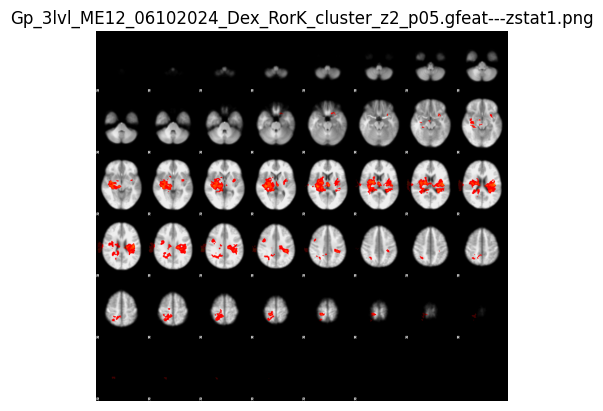

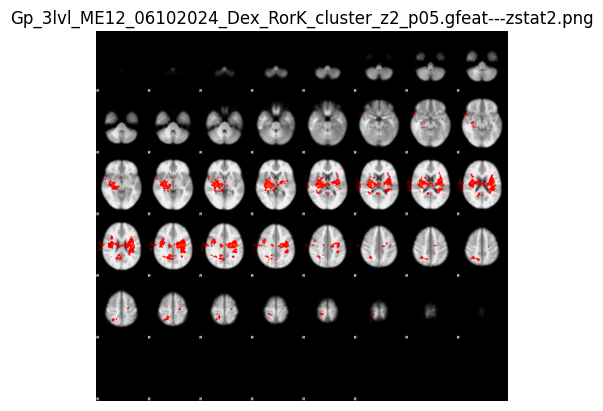

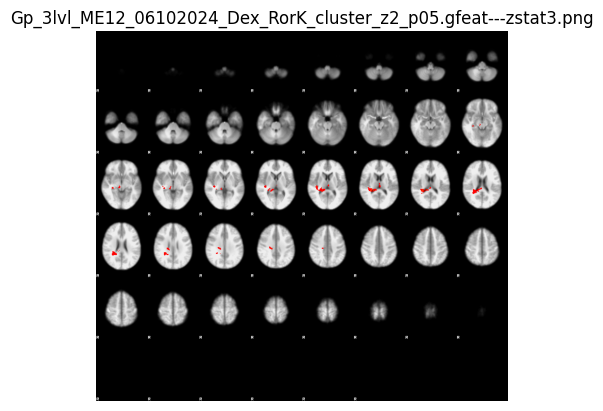

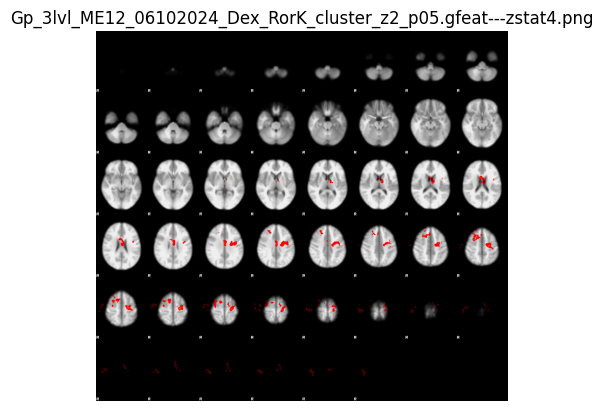

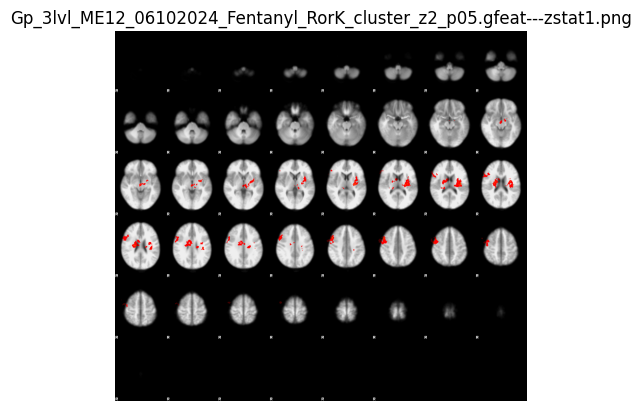

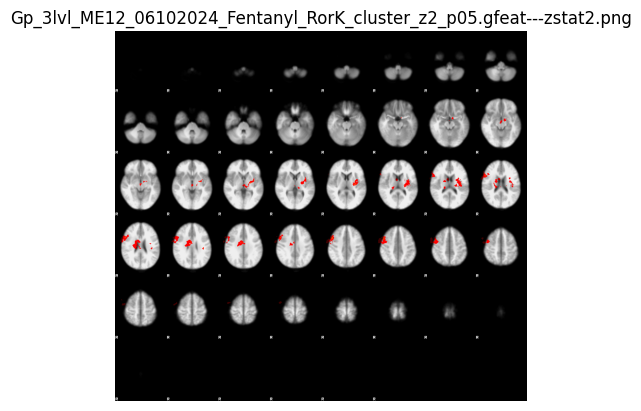

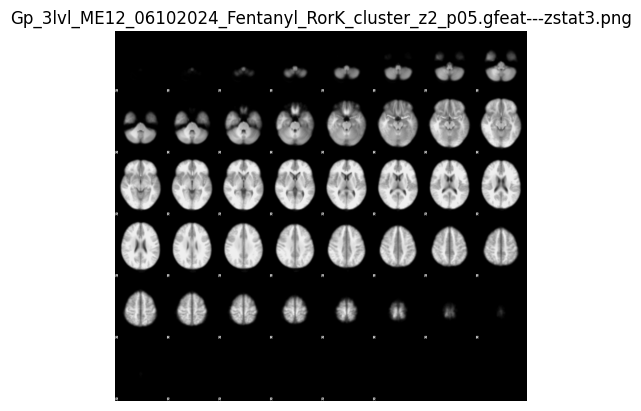

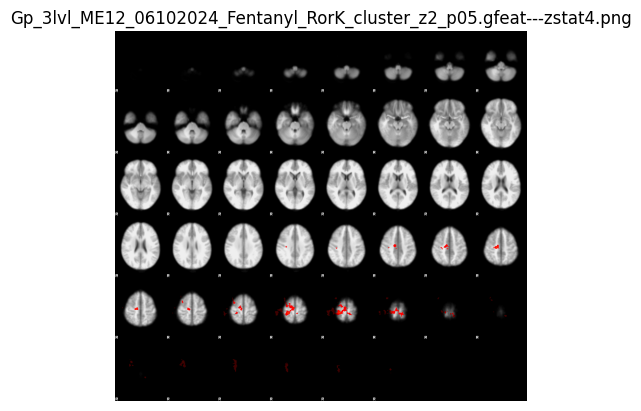

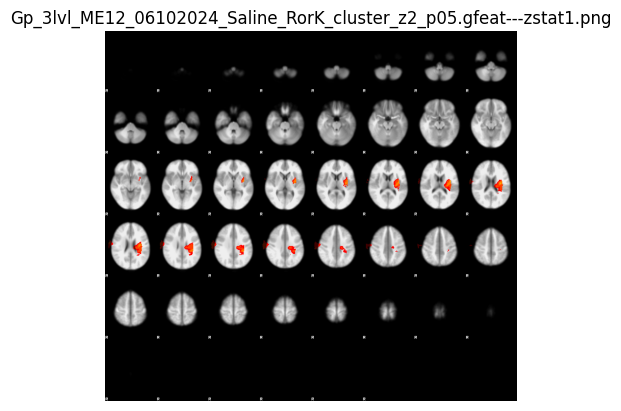

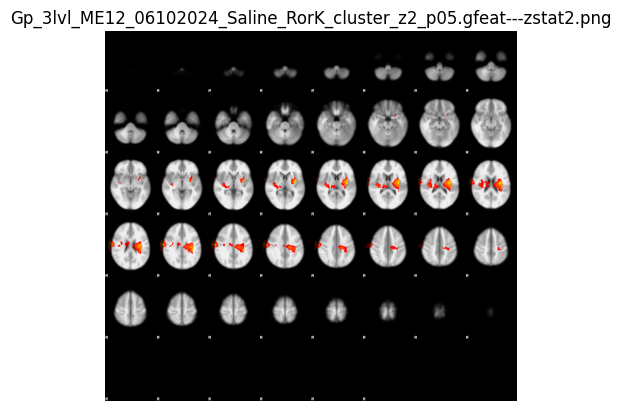

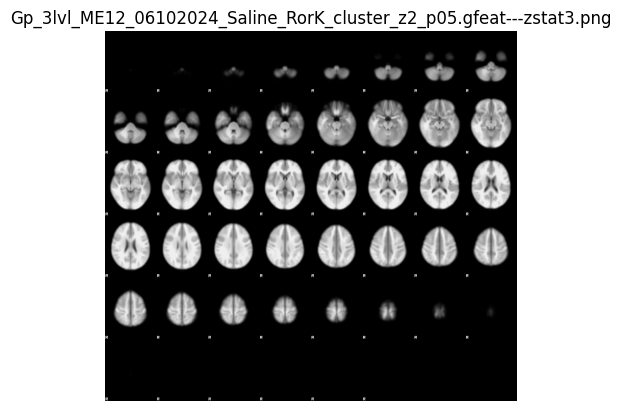

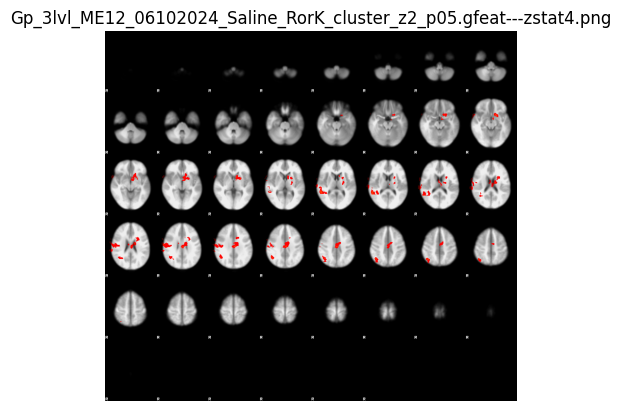

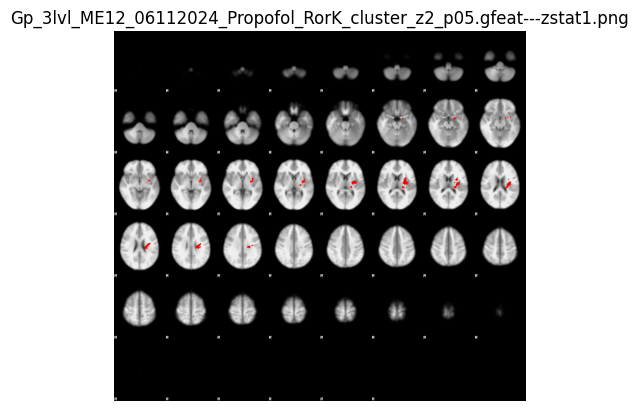

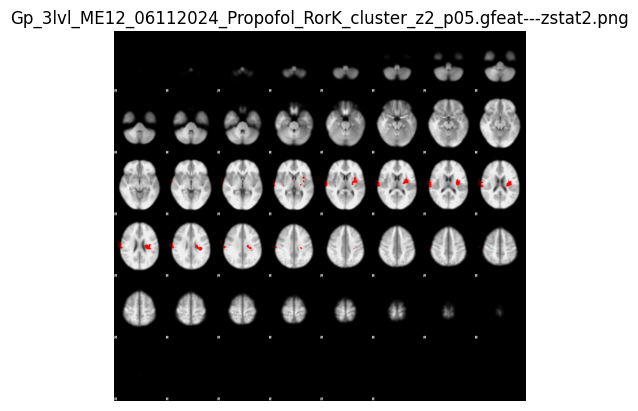

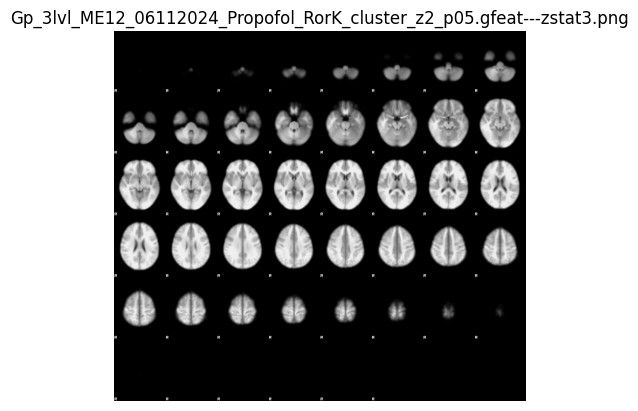

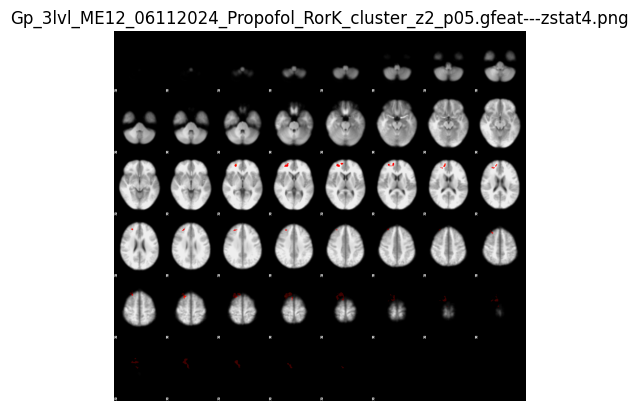

In [186]:
#print all the rendered_thresh_zstat*.png files in the MEM_gp_zstat_files with the corresponding title in the directory Mem_gp_zstat_ppt
for MEM_gp_zstat_file in MEM_gp_zstat_files:
    img = plt.imread(MEM_gp_zstat_file)
    plt.imshow(img)
    plt.title(os.path.abspath(MEM_gp_zstat_file).split('/')[8] + '---' + (os.path.abspath(MEM_gp_zstat_file).split('/')[10]).split('_')[2])
    plt.axis('off')
    # save the output as a jpg file
    plt.savefig(MEM_gp_zstat_file.replace('.png', '.jpg'))
    
    plt.show()

In [187]:
# get all the rendered_thresh_zstat*.jpg files in the FSL_Mem directory
MEM_gp_zstat_files_jpg = glob.glob(FSL_Mem + '/Gp_3lvl_*2024_*_RorK_cluster_z2_p05.gfeat/cope*.feat/rendered_thresh_zstat*.jpg')
MEM_gp_zstat_files_jpg.sort()
MEM_gp_zstat_files_jpg

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat1.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat2.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat3.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Dex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat1.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat2.jpg',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_ME12_06102024_Fentanyl_RorK_cluster_z2

In [188]:
# copy all the rendered_thresh_zstat*.jpg files in the FSL_Mem directory to the new directory MEM_gp_zstat_ppt
for i in range(len(MEM_gp_zstat_files_jpg)):
    # copy the jpg files to the MEM_gp_zstat_ppt directory as new filenames
    shutil.copy(MEM_gp_zstat_files_jpg[i], Mem_gp_zstat_ppt + '/' + str(i+1) + '_' + os.path.basename(MEM_gp_zstat_files_jpg[i]))

### MEM Full Sample Size : N=138

In [49]:
# get all the reports in the FSL_Mem directory
MEM_gp_zstat_reports = glob.glob(FSL_Mem + '/Gp_3lvl_N-138_ME12_06*2024_*_RorK_cluster_z2_p05.gfeat/cope*.feat/report_poststats.html')
MEM_gp_zstat_reports.sort()
MEM_gp_zstat_reports

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_Fen-All_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_Sal-Avg_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_SalvsDex_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_SalvsFen_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_SalvsPro_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_RorK_cluster_z2_p05.gfeat/cope1.feat/report_poststats.html',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_0620

In [50]:
# open all report.html files in the MEM_gp_zstat_reports in a new browser window
for MEM_gp_report in MEM_gp_zstat_reports:
    subprocess.run(['open', MEM_gp_report])

In [54]:
# get all zstat PNGs in the FSL_Mem directory for N=138
MEM_gp_zstat_pngs = glob.glob(FSL_Mem + '/Gp_3lvl_N-138_ME12_06202024_*_FGT_cluster_z2_p05.gfeat/cope*.feat/rendered_thresh_zstat*.png')
MEM_gp_zstat_pngs.sort()
MEM_gp_zstat_pngs

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat3.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat5.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat6.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat7.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Fen-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Fen-All_FGT_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat5.png',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp

### SHK PNGs re-done

In [ ]:
# get all zstat .nii.gz files in the FSL_Mem directory for N=138
MEM_gp_zstat_nii = glob.glob(FSL_Mem + '/Gp_3lvl_N-138_ME12_06*2024_*_RorK_cluster_z2_p05.gfeat/cope*.feat/rendered_thresh_zstat*.nii.gz')
MEM_gp_zstat_nii.sort()
MEM_gp_zstat_nii

The cell below is done for rectifying an error in SHK results-globbing by replicating a FSL-genertated rendered_thresh_zstat*.png for maintaining the title in PPT images.

In [5]:
# for all the zstat .nii.gz files in the FSL_Mem directory for N=138, do a fsl subprocess by calling slicer
for MEM_gp_zstat_nii_file in MEM_gp_zstat_nii:
    # call the slicer function for the zstat .nii.gz files
    subprocess.run(['slicer', MEM_gp_zstat_nii_file, '-S', '2', '750', MEM_gp_zstat_nii_file.replace('.nii.gz', '.png')])

### Saving PNGs with corresponding titles for PPT view

All z-maps for RorK, SHK, and FGT results are saved as a PNG for populating in the slide deck in Pitt OneDrive: **MCA MEM Group Results - Full Sample - 06*2024.pptx**. First they are saved in Cerebro's **/FSL_Mem/Mem_gp_zstat_ppt_n138/** for easy locating.

In [56]:
# make a directory to save the rendered_thresh_zstat*.png files in the FSL_Pain directory as a PPT file
Mem_gp_zstat_ppt_n138 = FSL_Mem + '/Mem_gp_zstat_ppt_n138/FGT' # '/RorK' or '/SHK'
os.makedirs(Mem_gp_zstat_ppt_n138, exist_ok=True)


In [30]:
# trial run for extracting labels from the MEM_gp_zstat_files
print((os.path.abspath('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06182024_SalvsDex_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[8]).split('_')[5])
print((os.path.abspath('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[8]).split('_')[5])
print(Mem_gp_zstat_ppt_n138 + '/' + (('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[8]).split('_')[5] + '-FGT-' + ('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Gp_3lvl_N-138_ME12_06202024_Dex-All_RorK_cluster_z2_p05.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[10])


SalvsDex
Dex-All


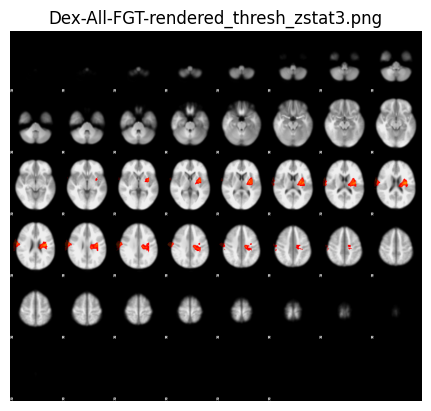

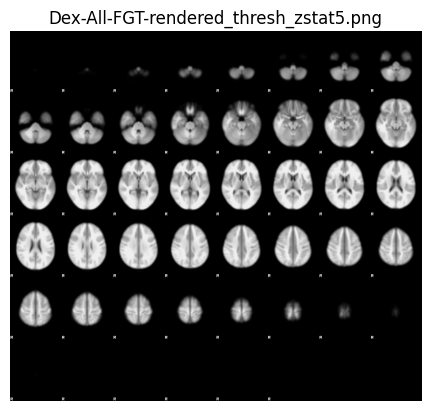

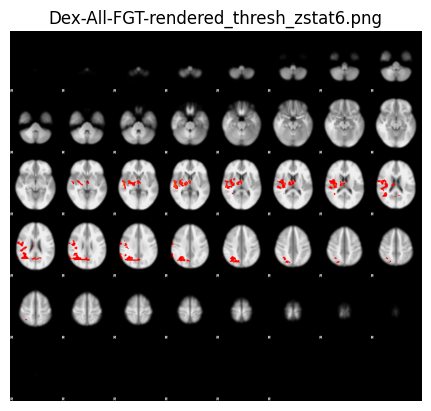

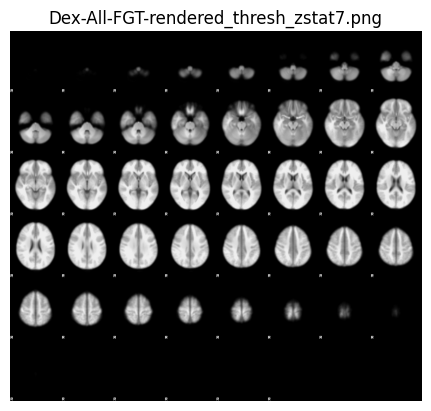

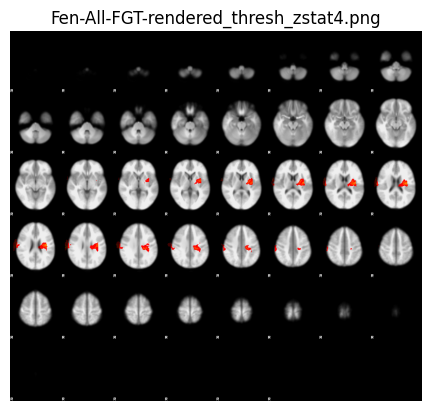

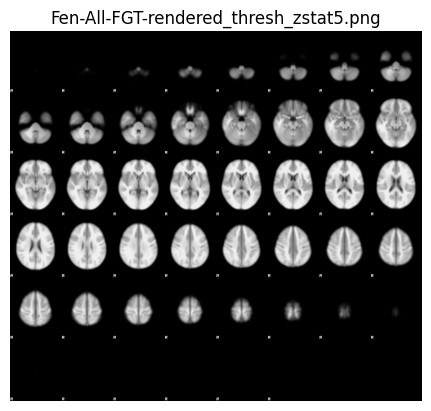

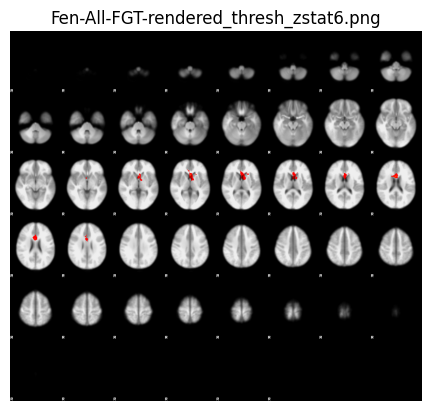

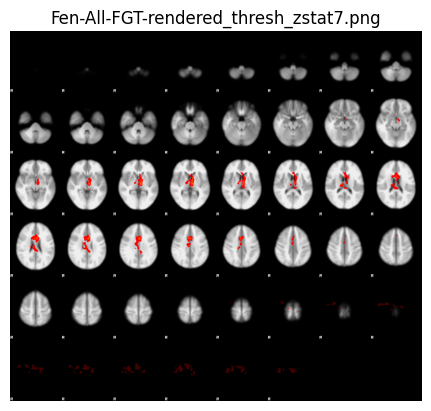

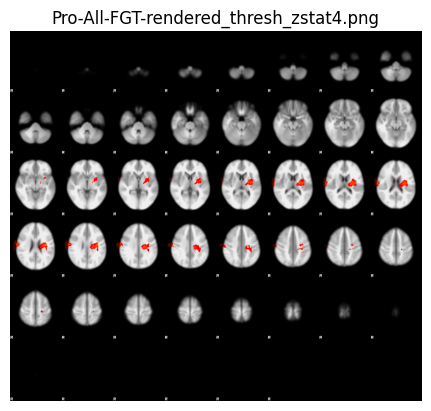

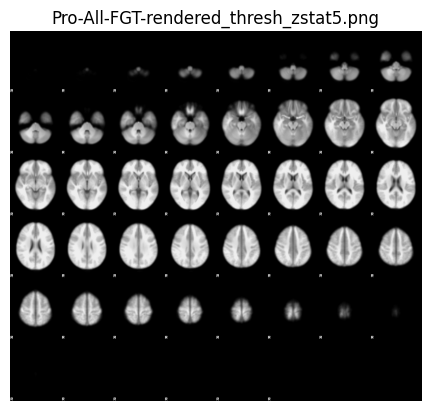

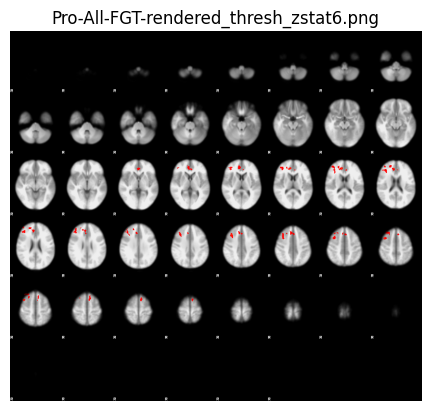

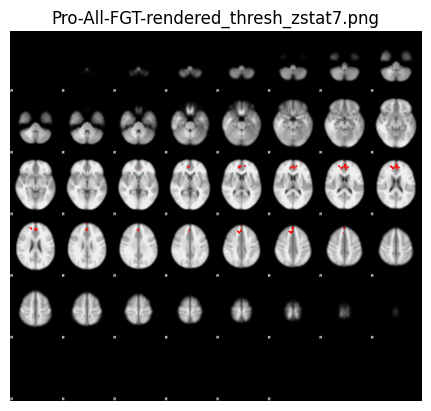

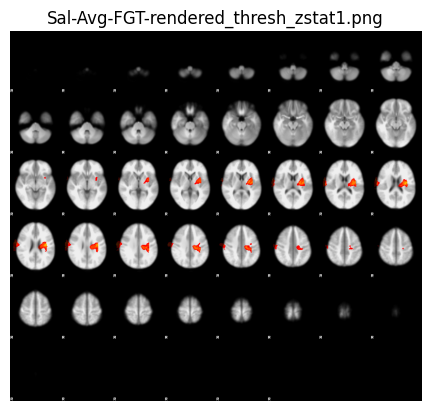

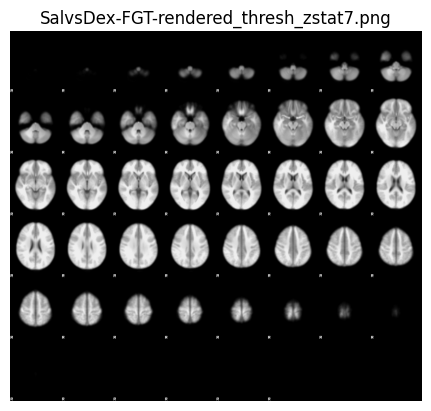

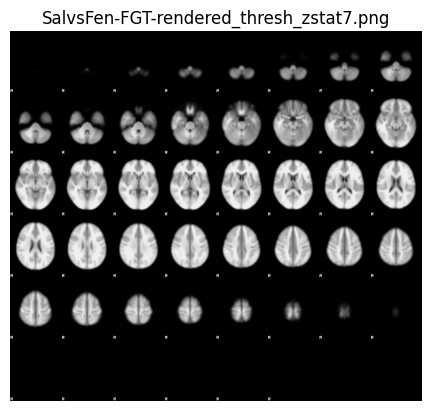

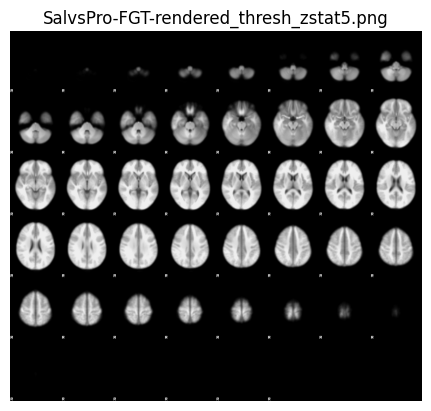

In [55]:
#print all the rendered_thresh_zstat*.png files in the MEM_gp_zstat_files with the corresponding title in the directory Mem_gp_zstat_ppt_n138
for MEM_gp_zstat_png in MEM_gp_zstat_pngs:
    img = plt.imread(MEM_gp_zstat_png)
    plt.imshow(img)
    plt.title(os.path.abspath(MEM_gp_zstat_png).split('/')[8].split('_')[5] + '-FGT-' + os.path.abspath(MEM_gp_zstat_png).split('/')[10])
    plt.axis('off')
    # save the output as a PNG file renamed as the title
    plt.savefig(Mem_gp_zstat_ppt_n138 + '/' + os.path.abspath(MEM_gp_zstat_png).split('/')[8]+ '---' + os.path.abspath(MEM_gp_zstat_png).split('/')[10])
    
    plt.show()

In [32]:
help(plot_img_on_surf)

Help on function plot_img_on_surf in module nilearn.plotting.surf_plotting:

plot_img_on_surf(stat_map, surf_mesh='fsaverage5', mask_img=None, hemispheres=['left', 'right'], bg_on_data=False, inflate=False, views=['lateral', 'medial'], output_file=None, title=None, colorbar=True, vmin=None, vmax=None, threshold=None, symmetric_cbar='auto', cmap='cold_hot', cbar_tick_format='%i', **kwargs)
    Plot multiple views of plot_surf_stat_map     in a single figure.

    It projects stat_map into meshes and plots views of
    left and right hemispheres. The *views* argument defines the views
    that are shown. This function returns the fig, axes elements from
    matplotlib unless kwargs sets and output_file, in which case nothing
    is returned.

    Parameters
    ----------
    stat_map : :obj:`str` or :class:`pathlib.Path` or 3D Niimg-like object
        See :ref:`extracting_data`.

    surf_mesh : str, dict, or None, default='fsaverage5'
        If str, either one of the two:
        'fs

In [48]:
os.path.abspath(zstat_file).split('/')[8]+ '---' + os.path.abspath(zstat_file).split('/')[10]

'GpAna-Dex-Avg_ME1+2_p05_05212024.gfeat---thresh_zstat3.nii.gz'

In [ ]:
# FSL slicer
for MEM_Third_Level_Stat_File in MEM_Third_Level_Stat_Files:
    # call the slicer function for the zstat .nii.gz files
    subprocess.run(['slicer', MEM_Third_Level_Stat_File, '-S', '2', '750', MEM_Third_Level_Stat_File.replace('.nii.gz', '.png')])

The above command does wrong overlay of zstat map activation as seen in /Thresh_zstat_PNGs/ subfolder. Nilearn figures are generated as below:

## MCA Group Results - Revised after Resolving FSL REG error - NILEARN FIGURES

In [8]:
MNI_filefor_PNGs='/Volumes/MRIcroGL/MRIcroGL.app/Contents/Resources/standard/mni152.nii.gz'

### MEM 

### All Drugs and Saline Conditions 

In [8]:
MEM_Third_Level_Stat_Files = glob.glob(FSL_Mem + '/Third_Level_Group_Analyses/Gp_3lvl_N138_ME12_07162024_Sal-Avg_RorK_cluster_z2_p05.gfeat/cope*.feat/thresh_zstat1.nii.gz')
MEM_Third_Level_Stat_Files.sort()
MEM_Third_Level_Stat_Files

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_N138_ME12_07162024_Sal-Avg_RorK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz']

Trial cell for figure titles:

In [75]:
MEM_Third_Level_Stat_File = os.path.abspath('/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_N138_ME12_07172024_Sal-Avg_SHK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz')
t1 = (os.path.abspath(MEM_Third_Level_Stat_File).split('/')[9]).replace('.gfeat', '')
print(t1)

Gp_3lvl_N138_ME12_07172024_Sal-Avg_SHK_cluster_z2_p05


In [ ]:
# FSL slice
for MEM_Third_Level_Stat_File in MEM_Third_Level_Stat_Files:
    # call the slicer function for the zstat .nii.gz files
    subprocess.run(['slicer', MEM_Third_Level_Stat_File, '-S', '2', '750', MEM_Third_Level_Stat_File.replace('.nii.gz', '.png')])

The above command does wrong overlay of zstat map activation as seen in /Thresh_zstat_PNGs/ subfolder. Nilearn figures are generated as below:

Since the figures generated from FSL slicer as above creates less interpretable image mosaics, nilearn plotting is used as shown below (similar to Pain data). RorK, SHK, and FGT are sub-folders in the axial view **nilearn_PNGs/**.


In [10]:
savepath='/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/nilearn_PNGs/axial/' # ./nilearn_PNGs/ or /MRIcroGL_PNGs/ for s/w  # /example_fig_types/ have the Sal_Avg in different fig displays
MNI_filefor_PNGs='/Volumes/MRIcroGL/MRIcroGL.app/Contents/Resources/standard/mni152.nii.gz'

In [87]:
#details on the options for plot_stat_map
help(plot_stat_map)

Help on function plot_stat_map in module nilearn.plotting.img_plotting:

plot_stat_map(stat_map_img, bg_img=<MNI152Template>, cut_coords=None, output_file=None, display_mode='ortho', colorbar=True, cbar_tick_format='%.2g', figure=None, axes=None, title=None, threshold=1e-06, annotate=True, draw_cross=True, black_bg='auto', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x13c6f0b60>, symmetric_cbar='auto', dim='auto', vmin=None, vmax=None, radiological=False, resampling_interpolation='continuous', **kwargs)
    Plot cuts of an ROI/mask image.

    By default 3 cuts: Frontal, Axial, and Lateral.

    Parameters
    ----------
    stat_map_img : Niimg-like object
        See :ref:`extracting_data`.
        The statistical map image

    bg_img : Niimg-like object, optional
        See :ref:`extracting_data`.
        The background image to plot on top of.
        If nothing is specified, the MNI152 template will be used.
        To turn off background image, just pass "bg_img=N

/usr/local/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


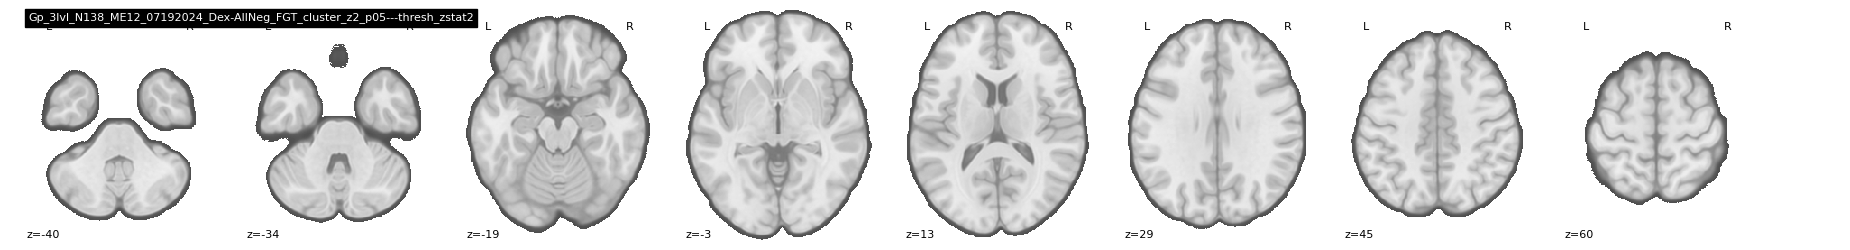

In [90]:
# trial axial slice set for plotting MEM_Third_Level_Stat_File
title = (os.path.abspath(MEM_Third_Level_Stat_File).split('/')[9]).replace('.gfeat', '') + '---' + os.path.abspath(MEM_Third_Level_Stat_File).split('/')[11].replace('.nii.gz', '')
display1 = plot_stat_map(MEM_Third_Level_Stat_File, display_mode="z", cut_coords=[-40, -34, -19, -3, 13, 29, 45, 60], black_bg=False, colorbar=True, threshold=2, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap='hot')
display1.title((title), size=8)
display1.annotate(size=8)
display1.savefig(savepath+title+str('_axial.png'))
plt.show()

In [13]:
# load and display the zstat files from MEM_Third_Level_Stat_Files
for MEM_Third_Level_Stat_File in MEM_Third_Level_Stat_Files:
    title = (os.path.abspath(MEM_Third_Level_Stat_File).split('/')[9]).replace('.gfeat', '') + '---' + os.path.abspath(MEM_Third_Level_Stat_File).split('/')[11].replace('.nii.gz', '')
    
    # if title contains Neg, set the cmap to Blues else set it to hot
    if 'Neg' in title:
        cmap_choice = 'Blues'
    else:
        cmap_choice = 'hot'

    # #FIG 1
    # # plot the zstat file; Set vmin and vmax to the minimum and maximum values of the zstat file; edit to 2-8 if necessary
    # display1 = plot_stat_map(MEM_Third_Level_Stat_File, display_mode="mosaic", black_bg=False, colorbar=True, threshold=2, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap='hot')
    # display1.title((title), size=8)
    # display1.annotate(size=8)
    # display1.savefig(savepath+title+str('_mosaic.png'))
    # plt.show()

    # #FIG 2
    # display2 = plot_stat_map(MEM_Third_Level_Stat_File, display_mode='tiled', black_bg=False, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=False, bg_img=MNI_filefor_PNGs, cmap='hot')
    # display2.title((title), size=8)
    # display2.annotate(size=8)
    # display2.savefig(savepath+title+str('_tiled.png'))
    # plt.show()

    # #FIG 3
    # display3 = plot_glass_brain(MEM_Third_Level_Stat_File, display_mode='lyrz', black_bg=False, title=title, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=True, bg_img=MNI_filefor_PNGs)
    # display3.savefig(savepath+title+str('_glass.png'))
    # plt.show()

    #FIG 4
    # plot_img_on_surf(MEM_Third_Level_Stat_File, surf_mesh='fsaverage', hemispheres=['left', 'right'], threshold=2, colorbar=True, title=title, cmap='hot', title_font_size=8, output_file=savepath+title+str('_surf.png'))
    # plt.show()

    #FIG 5
    plot_img_on_surf(MEM_Third_Level_Stat_File, surf_mesh='fsaverage', hemispheres=['left', 'right'], inflate=True, threshold=2, colorbar=True, title=title, cmap='hot', title_font_size=8, output_file=savepath+title+str('_surf_inflate.png'))
    # plt.show()
    
    # FIG 6 : axial slice set from -24 to 50 
    # display4 = plot_stat_map(MEM_Third_Level_Stat_File, display_mode="z", cut_coords=[-24, -20, -16, -10, 0, 10, 20, 30, 40 ,50], black_bg=False, colorbar=True, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap=cmap_choice)

    # display4.title((title), size=8)
    # display4.annotate(size=8)
    # display4.savefig(savepath+title+str('_axial.png'))
    # plt.show()

### Females vs Males - Drug-wise Group Runs

In [5]:
MEM_Third_Level_Stat_Files_FvsM = glob.glob(FSL_Mem + '/Third_Level_Group_Analyses/Gp_3lvl_ME12_07*2024_*-FvsM_*_cluster_z2_p05*.gfeat/cope*.feat/thresh_zstat1.nii.gz')
MEM_Third_Level_Stat_Files_FvsM.sort()
MEM_Third_Level_Stat_Files_FvsM

['/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Dex-FvsM_RorK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Dex-FvsM_SHK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Fentanyl-FvsM_RorK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Fentanyl-FvsM_SHK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Propofol-FvsM_RorK_cluster_z2_p05.gfeat/cope1.feat/thresh_zstat1.nii.gz',
 '/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/Gp_3lvl_ME12_07262024_Propofol-Fvs

In [6]:
savepath='/Volumes/cerebro/Studies/MCA_FMRI/Public/Data/FSL_Mem/Third_Level_Group_Analyses/nilearn_PNGs/axial/Drug-wise_FvsM/' # nilearn_PNGs or MRIcroGL_PNGs
MNI_filefor_PNGs='/Volumes/MRIcroGL/MRIcroGL.app/Contents/Resources/standard/mni152.nii.gz'

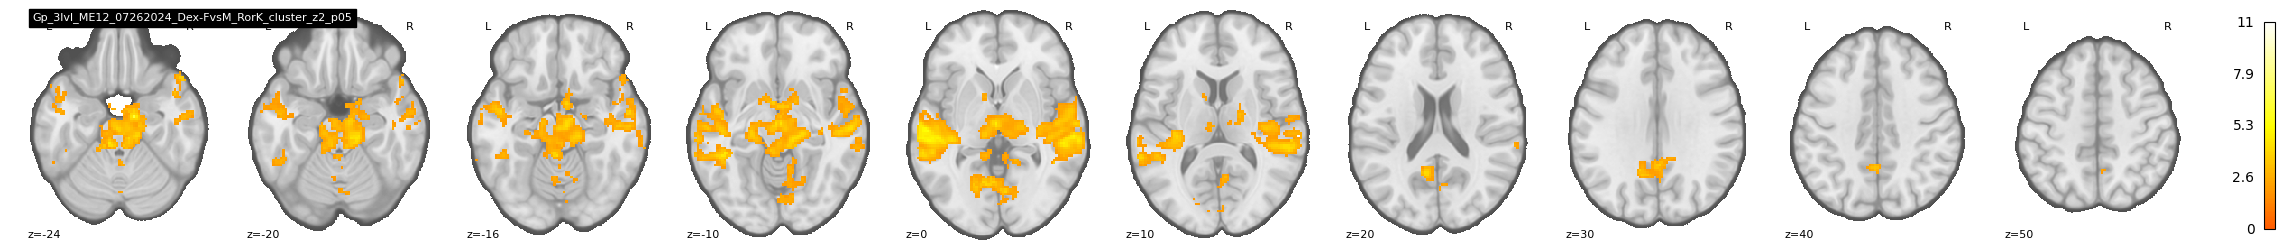

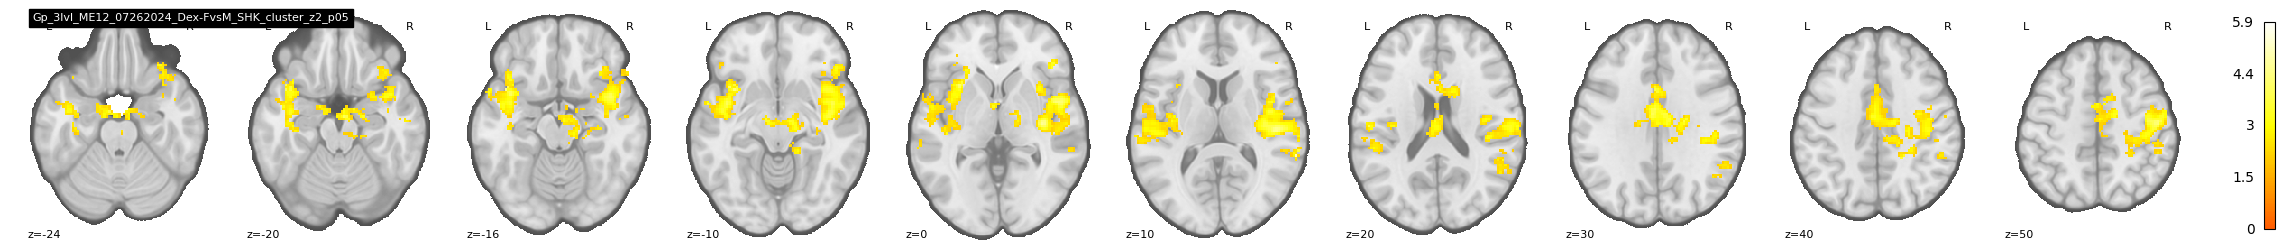

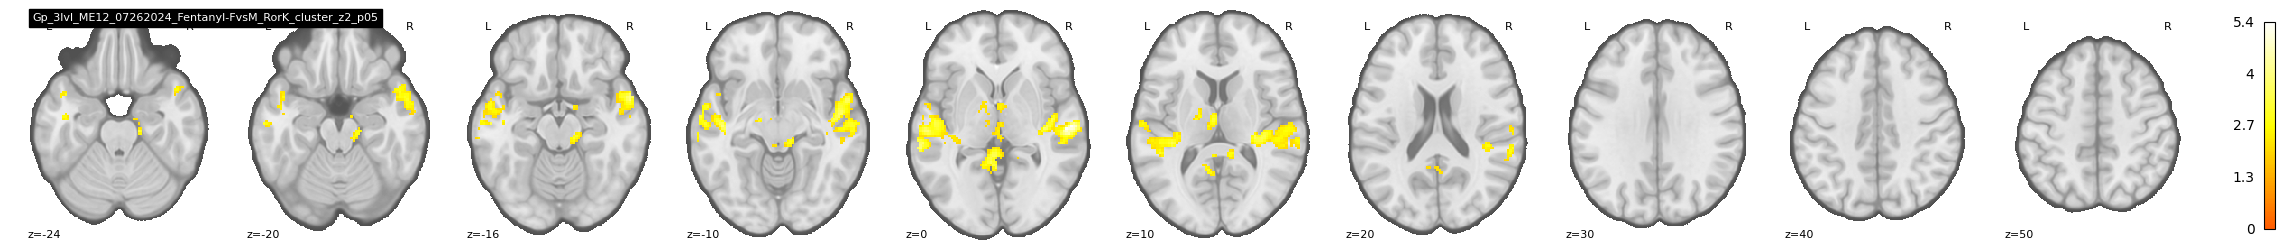

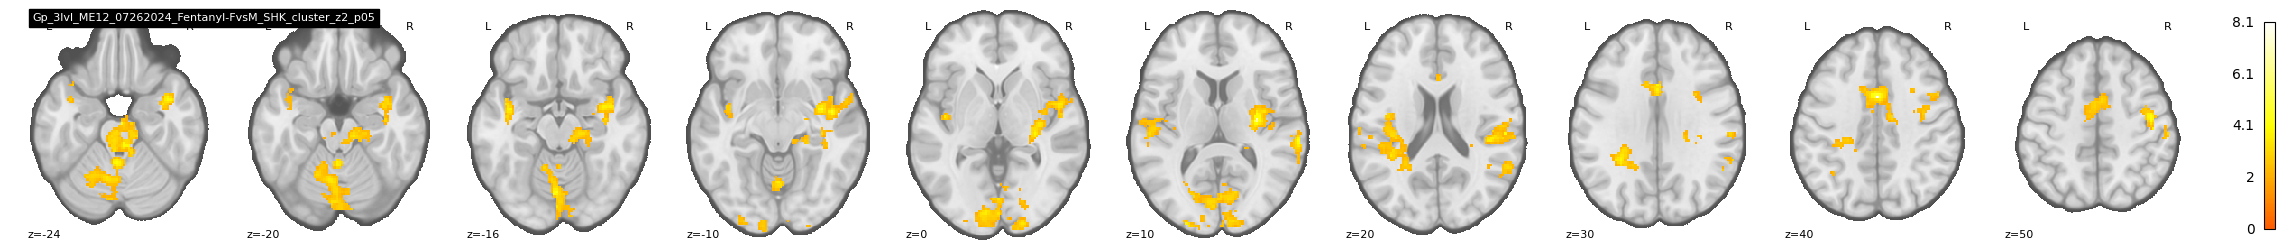

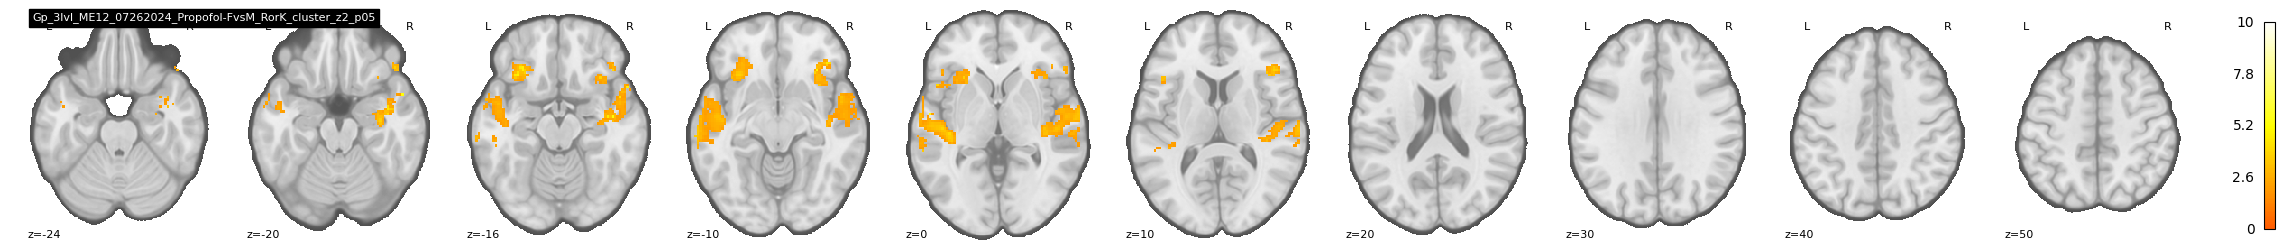

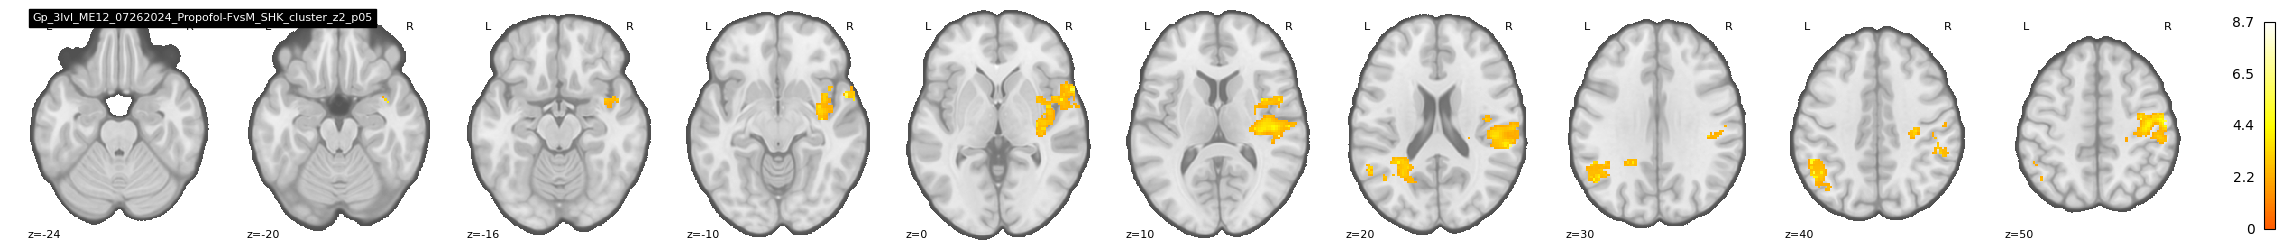

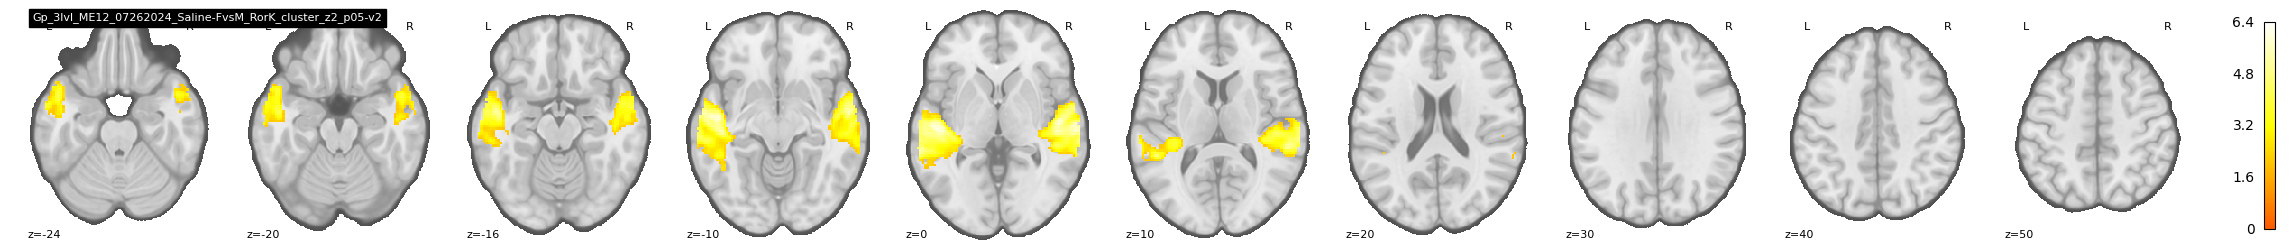

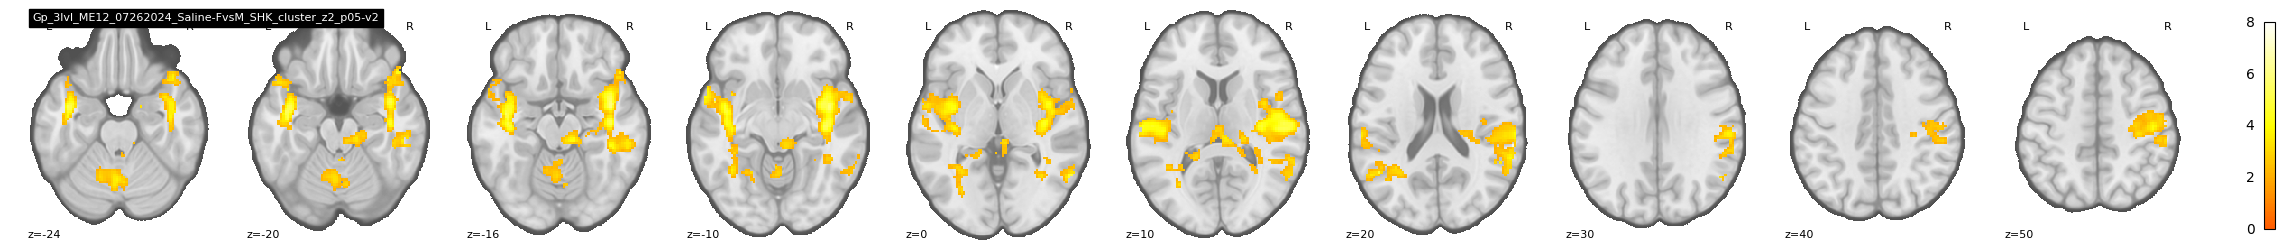

In [7]:
# load the zstat files from MEM_Third_Level_Stat_Files
for MEM_Third_Level_Stat_File_FvsM in MEM_Third_Level_Stat_Files_FvsM:
    # title = (os.path.abspath(MEM_Third_Level_Stat_File_FvsM).split('/')[9]).replace('.gfeat', '') + '---' + os.path.abspath(MEM_Third_Level_Stat_File_FvsM).split('/')[11].replace('.nii.gz', '')
    title = (os.path.abspath(MEM_Third_Level_Stat_File_FvsM).split('/')[9]).replace('.gfeat', '') # + '---Avg'
    cmap_choice = 'hot'
    
    # # if title contains Neg, set the cmap to Blues else set it to hot
    # if 'Neg' in title:
    #     cmap_choice = 'Blues'
    # else:
    #     cmap_choice = 'hot'

    # #FIG 1
    # # plot the zstat file; Set vmin and vmax to the minimum and maximum values of the zstat file; edit to 2-8 if necessary
    # display1 = plot_stat_map(MEM_Third_Level_Stat_File_FvsM, display_mode="mosaic", black_bg=False, colorbar=True, threshold=2, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap='hot')
    # display1.title((title), size=8)
    # display1.annotate(size=8)
    # display1.savefig(savepath+title+str('_mosaic.png'))
    # plt.show()

    # #FIG 2
    # display2 = plot_stat_map(MEM_Third_Level_Stat_File_FvsM, display_mode='tiled', black_bg=False, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=False, bg_img=MNI_filefor_PNGs, cmap='hot')
    # display2.title((title), size=8)
    # display2.annotate(size=8)
    # display2.savefig(savepath+title+str('_tiled.png'))
    # plt.show()

    # #FIG 3
    # display3 = plot_glass_brain(MEM_Third_Level_Stat_File_FvsM, display_mode='lyrz', black_bg=False, title=title, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=True, bg_img=MNI_filefor_PNGs)
    # display3.savefig(savepath+title+str('_glass.png'))
    # plt.show()

    # #FIG 4
    # plot_img_on_surf(MEM_Third_Level_Stat_File_FvsM, surf_mesh='fsaverage', hemispheres=['left', 'right'], threshold=2, colorbar=True, title=title, cmap='hot', title_font_size=8, output_file=savepath+title+str('_surf.png'))
    # plt.show()

    # #FIG 5
    # plot_img_on_surf(MEM_Third_Level_Stat_File_FvsM, surf_mesh='fsaverage', hemispheres=['left', 'right'], inflate=True, threshold=2, colorbar=True, title=title, cmap='hot', title_font_size=8, output_file=savepath+title+str('_surf_inflate.png'))
    # plt.show()
    
    #FIG 6 : axial slice set from -24 to 50 
    display4 = plot_stat_map(MEM_Third_Level_Stat_File_FvsM, display_mode="z", cut_coords=[-24, -20, -16, -10, 0, 10, 20, 30, 40 ,50], black_bg=False, colorbar=True, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap=cmap_choice)

    display4.title((title), size=8)
    display4.annotate(size=8)
    display4.savefig(savepath+title+str('_axial.png'))
    plt.show()